# Atmospheric Carbon

How much carbon is emitted into the atmosphere depends on degassing at ridges and and arcs. This relies on outputs from all previous notebooks.

In [1]:
import numpy as np
import matplotlib
import gplately
import gplately.tools as tools
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
from scipy.interpolate import RegularGridInterpolator
from scipy import ndimage
from IPython.display import clear_output
import pandas as pd
import glob, os
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
%matplotlib inline
# plt.style.use('ggplot')

# common variables
extent_globe = [-180, 180, -90, 90]
earth_radius = 6371.009e3
earth_surface_area = 4.0*np.pi*earth_radius**2

# netCDF4 grid resolution
spacingX = 0.2
spacingY = 0.2
lon_grid = np.arange(extent_globe[0], extent_globe[1]+spacingX, spacingX)
lat_grid = np.arange(extent_globe[2], extent_globe[3]+spacingY, spacingY)

# reconstruction time steps and spacing
min_time = 0
max_time = 1000
timestep_size = 1
reconstruction_times = np.arange(min_time, max_time+timestep_size, timestep_size)

In [2]:
# Change `folder_name`: a string to name a new sub-folder for a new set of Notebook 1 outputs; 
# useful for keeping track of reruns
folder_name = "Muller22_Apr21"

# Don't change this: directory to input files
output_directory = "./Outputs/{}/Notebook05/".format(folder_name)
os.makedirs(output_directory, exist_ok=True)
os.makedirs(output_directory+"/figures", exist_ok=True)
os.makedirs(output_directory+"/csv", exist_ok=True)

## Read csv files saved from previous notebooks

In [3]:
# MOR outgassing - 10Myr median filtered when saving csv
ridge_outflux_pd = pd.read_csv('./Outputs/{}/Notebook03/csv/03_ridge_outflux.csv'.format(folder_name), index_col=0, header=[0,1])
ridge_outflux_pd = ridge_outflux_pd.reindex(index=reconstruction_times)
ridge_outflux = ridge_outflux_pd.loc[:, (['outflux'], ['min', 'mean', 'max'])].to_numpy()
ridge_outflux_min = ridge_outflux_pd['outflux']['min'].to_numpy()
ridge_outflux_mean = ridge_outflux_pd['outflux']['mean'].to_numpy()
ridge_outflux_max = ridge_outflux_pd['outflux']['max'].to_numpy()

# subduction_outgassing - 10Myr median filtered (this depends on a 10-myr filtered output from 02_subducted_carbon)
subduction_outflux_pd = pd.read_csv('./Outputs/{}/Notebook03/csv/03_slab_outflux.csv'.format(folder_name), index_col=0, header=[0,1])
subduction_outflux_pd = subduction_outflux_pd.reindex(index=reconstruction_times)
subduction_outflux = subduction_outflux_pd.loc[:, (['outflux_total'], ['min', 'mean', 'max'])].to_numpy()
subduction_outflux_no_sediment = subduction_outflux - subduction_outflux_pd.loc[:, (['outflux_sediments'], ['min', 'mean', 'max'])].to_numpy()
# subduction_outflux *= 0.5 # half sticks around?

# carbonate platform outgassing (from notebook 5)- 10Myr median filtered when saving csv
percentage = 0.25
carbonate_platform_outflux = np.zeros((len(reconstruction_times), 3))
carbonate_platform_outflux_pd =  pd.read_csv("./Outputs/{}/Notebook04/csv/carbonate_platform_degassing_{}percent.csv".format(folder_name, percentage*100))
carbonate_platform_outflux_pd = carbonate_platform_outflux_pd.reindex(index=reconstruction_times)
carbonate_platform_outflux_min = carbonate_platform_outflux_pd.loc[:, ['min_carbonate_platform_degassing_rate']].to_numpy()
carbonate_platform_outflux_mean = carbonate_platform_outflux_pd.loc[:, ['mean_carbonate_platform_degassing_rate']].to_numpy()
carbonate_platform_outflux_max = carbonate_platform_outflux_pd.loc[:, ['max_carbonate_platform_degassing_rate']].to_numpy()
carbonate_platform_outflux[:,0] = np.ravel(carbonate_platform_outflux_min)
carbonate_platform_outflux[:,1] = np.ravel(carbonate_platform_outflux_mean)
carbonate_platform_outflux[:,2] = np.ravel(carbonate_platform_outflux_max)

# plate storage - 10Myr median filtered
plate_storage_pd = pd.read_csv('./Outputs/{}/Notebook03/csv/03_slab_storage.csv'.format(folder_name), index_col=0, header=[0,1])
plate_storage_pd = plate_storage_pd.reindex(index=reconstruction_times)
plate_storage = plate_storage_pd.loc[:, (['stored_total'], ['min', 'mean', 'max'])].to_numpy()

# plate influx - 10Myr median filtered
plate_influx = pd.read_csv('./Outputs/{}/Notebook02/csv/02_plate_influx.csv'.format(folder_name), index_col=0, header=[0,1])
plate_influx = plate_influx.reindex(index=reconstruction_times)
sediments_influx    = plate_influx.loc[:, (['sediments'], ['min', 'mean', 'max'])].to_numpy()
serpentinite_influx = plate_influx.loc[:, (['serpentinite_total'], ['min', 'mean', 'max'])].to_numpy()
crust_influx        = plate_influx.loc[:, (['crust'], ['min', 'mean', 'max'])].to_numpy()
upper_plate_influx  = sediments_influx + serpentinite_influx + crust_influx
upper_plate_influx_no_sediment = serpentinite_influx + crust_influx

# subducted carbon - 10Myr median filtered
subduction_influx = pd.read_csv('./Outputs/{}/Notebook02/csv/02_subducted_carbon.csv'.format(folder_name), index_col=0, header=[0,1])
subduction_influx = subduction_influx.reindex(index=reconstruction_times)

total_subduction_influx = subduction_influx.loc[:, (['total'], ['min', 'mean', 'max'])].to_numpy()

## Read other datasets from `./utils/`

In [4]:
# OTHER DATA SETS FOR PLOTTING
# Foster et al Atmospheric CO2 dataset
foster_data = np.loadtxt('./utils/AtmosphericCarbon/Foster_etal_carbon_cycles_250Ma_to_present_NatComms2017-s3.csv',
                         delimiter=',', skiprows=2, usecols=(0,3,1,4))
foster_age    = foster_data[:,0]
foster_carbon = foster_data[:,1:] #* 12.0107/44.0095 # convert t CO2 to Mt carbon from ratio of molecular weight

# Merdith et al. (2017) arc length (100-200 km  distance to the nearest cont margin)
arc_time_merdith, arc_len_merdith = np.loadtxt("./utils/AtmosphericCarbon/arc_length_250_0.csv", delimiter=',', usecols=(0,2), skiprows=1, unpack=True)

# Cao et al. (2017) arc length (100-200 km  distance to the nearest cont margin)
arc_time_cao, arc_len_cao = np.loadtxt("./utils/AtmosphericCarbon/age_cont_arc_length_250-0Ma_Cao_etal_2017.csv", delimiter='\t', usecols=(0,1), skiprows=1, unpack=True)

# Muller et al. (2019) (100-200 km  distance to the nearest cont margin)
arc_data_muller = np.loadtxt('./utils/AtmosphericCarbon/age_cont_arc_length_250-0Ma_Mulleretal2019.txt',
                         delimiter='\t', skiprows=1, usecols=(0,1,2,3))
arc_time_muller = arc_data_muller[:,0]
arc_len_muller_mean =  arc_data_muller[:,1]        
arc_len_muller_min =  arc_data_muller[:,2]
arc_len_muller_max =  arc_data_muller[:,3]  


# Pall et al. (2016)
arc_time, arc_len = np.loadtxt("./utils/AtmosphericCarbon/Pall_etal_2016_global_length_contarc.csv", delimiter=',', usecols=(0,1), skiprows=1, unpack=True)
arc_time_carb, arc_len_carb = np.loadtxt("./utils/AtmosphericCarbon/Pall_etal_2016_global_length_carbonate.csv", delimiter=',', usecols=(0,1), skiprows=1, unpack=True)


In [5]:
# Sea level change from change in ocean basin volume, from Wright et al. (2020)
# wright_age, wright_sealevel = np.loadtxt('age_sealevel_Wrightetal_2020.csv', delimiter='\t',
#                                          unpack=True, skiprows=1)

# Seawater Strontium curve, normalised by removing the signal caused by radioactive 87Rb decay in the crust, from Bataille et al. (2017) 
# bataille_age, bataille_sr = np.loadtxt('age_seawater_Sr_normalised_250-0Ma_Bataille_etal_2017.csv', delimiter='\t',
#                                          unpack=True, skiprows=1)

# CO2 concentration from phytane-based C)2 proxy estimates, from Witkowski et al. (2018)
witkowski_age, witkowski_carbon = np.loadtxt('./utils/AtmosphericCarbon/age_pCO2_250-0Ma_Witkowski_etal2018.csv', delimiter='\t',
                                          unpack=True, skiprows=1)

# Total land area from Marcilly et al. (2021) 
marcilly_total_land_age, marcilly_total_land = np.loadtxt('./utils/AtmosphericCarbon/age_total_exposed_land_250-0Ma_Marcilly_etal_2021.csv', delimiter='\t',
                                          unpack=True, skiprows=1)

# Percentage of total area in wet belts from 0-10 and 40-50 deg combined, from Marcilly et al. (2021) 
# marcilly_exp_land_age, marcilly_exp_land = np.loadtxt('age_total_exposed_land_250-0Ma_0-10_40-50deg_Marcilly_etal_2021.csv', delimiter='\t',
             
 #                                                     unpack=True, skiprows=1)

In [6]:
mills_data = np.loadtxt("./utils/AtmosphericCarbon/age_surface_temp_Mills_etal-2019_mean_min_max.txt", skiprows=1)
mills_time = mills_data[:,0]
mills_palaeotemp = mills_data[:,1:]

### Rift degassing outflux - bias-corrected rifts

#### Rift multiplier (Merdith et al., *in review*)

The Neoproterozoic and Early Palaeozoic database predominantly identifies rifts that form during continental breakup and/or terrane detachment and migration. The database of the review paper's Ref. 33 contains these rifts, and also rifts formed in convergent settings, such as back-arc basins. This is likely a function of preservation bias. To counteract this issue, we calculated the fraction of rifts formed in convergent settings, which for the period 450–0 Ma is 0.44 (i.e. on average 44% of total rift length in the database (33) formed in convergent settings and is unaccounted for in the estimate of ref(34)). Assuming that this proportion is constant back to 600 Ma, we applied a rift length multiplier of:

$1/0.56 \approx 1.79$

to all rift lengths earlier than 450Ma. 

In [7]:
rift_degassing_pd = pd.read_excel(
    "./utils/rift_degassing_2023dec01_rev2.xlsx",
      usecols=["Unnamed: 0", "Unnamed: 1"], header=0).drop([0, 1, 2, 3, 4],).rename(
    columns={'Unnamed: 0': 'time', 'Unnamed: 1': 'raw_rift_length'}
).reset_index(drop=True)

rift_times = rift_degassing_pd['time'].to_numpy()
raw_rift_length = rift_degassing_pd['raw_rift_length'].to_numpy()

multiplier_rift_length = []
for t, length in enumerate(raw_rift_length):
    if rift_times[t] > 450:
        new_length = length / 0.56
    else:
        new_length = length
    multiplier_rift_length.append(new_length)
    
# Apply a 20Myr window median filter to the multiplier rift lengths:
from scipy.signal import savgol_filter
import scipy.ndimage as sn

rift_time_window = 20

filtered_multiplier_rift_lengths = sn.median_filter(multiplier_rift_length, size=rift_time_window) # m to km
#filtered_multiplier_rift_lengths = savgol_filter(multiplier_rift_length, 21, 1)

### Scale rift degassing rates through time against present day rates.

This function requires the array of all reconstruction times, the present day rate and rift length to consider, and the array of all rift lengths through time.

### Scale rates for unbiased rifts (corrected for bias)

In [8]:
present_day_degassing = [13., 14.5, 16.]

def scale_rift_degassing_rates(reconstruction_times, present_day_rate, present_day_rift_length, rift_length_arr):
    
    final_degassing_rates = []
    present_day_rate_per_km = present_day_rate / present_day_rift_length
    
    for t, time in enumerate(reconstruction_times):
        degassing_rate = present_day_rate_per_km * rift_length_arr[t]
        final_degassing_rates.append(degassing_rate)
    return final_degassing_rates

min_degassing = scale_rift_degassing_rates(rift_times, present_day_degassing[0], filtered_multiplier_rift_lengths[0], filtered_multiplier_rift_lengths)
mean_degassing = scale_rift_degassing_rates(rift_times, present_day_degassing[1], filtered_multiplier_rift_lengths[0], filtered_multiplier_rift_lengths)
max_degassing = scale_rift_degassing_rates(rift_times, present_day_degassing[2], filtered_multiplier_rift_lengths[0], filtered_multiplier_rift_lengths)

### Rift degassing outflux - repeat for rifts non-corrected for bias (therefore, the biased rifts)

In [9]:
# Filter the raw rift lengths from the csv file.
filtered_raw_rift_lengths = sn.median_filter(raw_rift_length.astype(float), size=rift_time_window) # m to km

In [10]:
# Non-corrected == biased
min_degassing_non_corrected = scale_rift_degassing_rates(rift_times, present_day_degassing[0], filtered_raw_rift_lengths[0], filtered_raw_rift_lengths)
mean_degassing_non_corrected = scale_rift_degassing_rates(rift_times, present_day_degassing[1], filtered_raw_rift_lengths[0], filtered_raw_rift_lengths)
max_degassing_non_corrected = scale_rift_degassing_rates(rift_times, present_day_degassing[2], filtered_raw_rift_lengths[0], filtered_raw_rift_lengths)

## Atmospheric influx

1) Total subducted carbon
min, mean, max
68.17	100.585	139.69 Mt C/yr

2) Volcanic subduction zone degassing outflux from Bekaert et al. (2021)
min, mean, max
14.4 18.7 23 Mt C/yr

3) Percent of total slab flux degassing into the atmosphere (from combining (1) and (2))
46.0	48.4	55.5 Mt C/yr

4) Percent of total subducting carbon degassing into atmosphere:
min, mean, max
21.1 18.6 16.5 Mt C/yr

For present-day, we have two percentages, namely
 
total_outflux_percent (from subducting plate) (18.6% (21.1-16.5%) based on our model)
In comparison, the total_outflux_percent from Wong et al (2020) is 27% +/-16% at present (in same ballpark)
 
At present-day, we obtain the percentage of the subduction_outflux_percent (into sub-arc mantle) that is degassing into the atmosphere by
 
Atmospheric_subduction_outflux = total_outflux_percent x 100 / subduction_outflux_percent
 
We obtain:

Mean atmospheric_subduction_outflux = 18.6 x 100 / 48.4 = 38.4%

38.4% of our 48.4% that’s outgassed into the mantle needs to escape into the atmosphere so that 18.6% of the total comes out

5) percent of subducting carbon outgassed into the sub-arc mantle degassing into atmosphere:
45.9  38.4 29.65 Mt C/yr

These percentages become constants for our calculation, ie we take 38% of the subduction_outflux_percent at all times, and that provides us with the percentage of what comes out into the atmosphere of the mantle outflux.  This percentage is then applied to our carbon volume flux into the mantle to obtain the volume (in Mt C) through time of carbon going into the atmosphere. 

Bekaert, D.V., Turner, S.J., Broadley, M.W., Barnes, J.D., Halldórsson, S.A., Labidi, J., Wade, J., Walowski, K.J. and Barry, P.H., 2021. Subduction-driven volatile recycling: a global mass balance. Annual Review of Earth and Planetary Sciences, 49, pp.37-70.

/var/folders/m1/2fztkj494gsfjr4gb3w20swh0000gn/T/ipykernel_3558/1696137954.py:1: RuntimeWarning: divide by zero encountered in divide


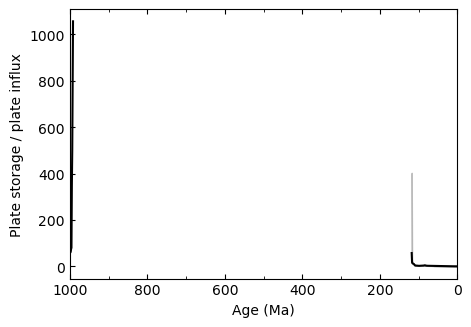

In [11]:
ratio_storage_to_plate_outflux = plate_storage/subduction_outflux

fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Plate storage / plate influx', xlim=[max_time,0])

ax.fill_between(reconstruction_times,
                ratio_storage_to_plate_outflux[:,0],
                ratio_storage_to_plate_outflux[:,2],
                color='0.5', alpha=0.5, label='Uncertainty')
ax.plot(reconstruction_times, ratio_storage_to_plate_outflux[:,1], c="k", label='Mean')
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
    

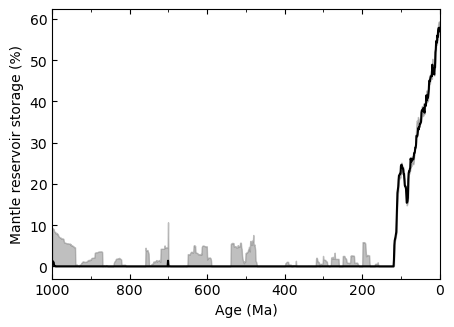

In [12]:
percentage_mantle_reservoir = subduction_outflux/total_subduction_influx*100

fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Mantle reservoir storage (%)', xlim=[max_time,0])

ax.fill_between(reconstruction_times,
                percentage_mantle_reservoir[:,0],
                percentage_mantle_reservoir[:,2],
                color='0.5', alpha=0.5, label='Uncertainty')
ax.plot(reconstruction_times, percentage_mantle_reservoir[:,1], c="k", label='Mean')
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)

#fig.savefig('percentage_mantle_reservoir.pdf', bbox_inches='tight')

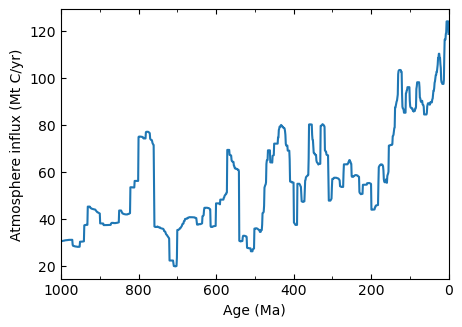

In [13]:
fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Atmosphere influx (Mt C/yr)', xlim=[max_time,0])

ax.plot(reconstruction_times, total_subduction_influx[:,1])
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)


### Total slab outflux

The total slab outflux from this model at 0 Ma is shown below:


### Note that these values are subject to change when using different plate models, as well as making adjustments in previous notebooks to parameters that affect the carbon reservoirs. 

In [14]:
print("Minimum: ", subduction_outflux[0][0], " Mt C/yr")
print("Mean: ", subduction_outflux[0][1], " Mt C/yr")
print("Maximum: ", subduction_outflux[0][2], " Mt C/yr")

Minimum:  59.20037416722951  Mt C/yr
Mean:  67.58431525535428  Mt C/yr
Maximum:  77.56196595746128  Mt C/yr


In the cell below, we estimate the minimum, mean and maximum percentages of total slab outflux that **are not attributable to carbonate platform degassing**.

### Accounting for atmospheric outgassing from carbonate platforms

###  4. Obtain a scaling parameter to scale NON carbonate platform degassing outflux through time

Here we compute subduction outflux calibrated with the present-day volcanic degassing estimate of **44.1 +/- 16.6 Mt C/yr** comprised of 

1. Volcanic outgassing from Bekaert et al. [2021], estimated at 18.7 +/- 4.3 Mt C/yr (min 14.4, mean 18.7, max 23.0 Mt C/yr) (out of the mean total slab outflux of 48.4 Mt C/yr). 
2. Diffuse outgassing from Fischer et al. [2019] of 25.35 +/- 12.27 Mt C/yr.

An estimated 70-80% of mean subduction outflux by high-temperature volcanic degassing (18.7 +/- 4.3 Mt C/yr) IS NOT attributed to carbonate platform degassing (Aiuppa et al. (2017)).

Therefore,

10.  **Maximum**: $ 0.8 \space \times \space 23 = 18.4 \space \text{Mt C/yr}$ 
11.  **Mean**: $ 0.75 \space \times \space 18.7 = 14.0 \space \text{Mt C/yr}$  
12.  **Minimum**: $ 0.70 \space \times \space 14.4 = 10.1 \space \text{Mt C/yr}$ 

We assume that an estimated 0-20% of mean subduction outflux by diffuse degassing from Fischer et al. [2019] of 25.35 +/- 12.27 Mt C/yr IS NOT attributed to carbonate platform degassing.


13.  **Maximum**: $ 0.2 \space \times \space 37.62 = 7.5 \space \text{Mt C/yr}$ 
14.  **Mean**: $ 0.1 \space \times \space 25.35 = 2.5 \space \text{Mt C/yr}$  
15.  **Minimum**: $ 0 \space \times \space 13.1 = 0 \space \text{Mt C/yr}$ 


The sum of these two estimates is:

16.  **Maximum**: $ 18.4 + 7.5 \space \times \space = 25.9 \space \text{Mt C/yr}$ 
17.  **Mean**: $ 14.0 + 2.5 \space \times \space = 16.5 \space \text{Mt C/yr}$  
18.  **Minimum**: $ 10.1 + 0 \space \times \space = 10.1 \space \text{Mt C/yr}$ 


In [15]:
is_not_carbonate_platform = [
    10.1,
    16.5,
    25.9
]

In [16]:
min_percentage  = is_not_carbonate_platform[0] * 100/subduction_outflux[0][0]
mean_percentage = is_not_carbonate_platform[1] * 100/subduction_outflux[0][1]
max_percentage  = is_not_carbonate_platform[2] * 100/subduction_outflux[0][2]

print("min, mean, max percentage: ", min_percentage, mean_percentage, max_percentage)

constant_percentage = mean_percentage/100 #np.ceil(np.median([min_percentage, mean_percentage, max_percentage]))/100

print("Constant percentage: ", constant_percentage*100, "%")

min, mean, max percentage:  17.06070298047352 24.41394861760149 33.3926553824136
Constant percentage:  24.41394861760149 %


### Comparing recycling efficiency factors
For comparison with Keleman and Manning (2015), who provided a recycling efficiency factor of 28% based on the ratio between total subducting carbon influx into the mantle and atmospheric outgassing, the equivalent numbers for our model are:

In [17]:
# Bekaert outflux not attributable to carbonate platform degassing using our model outputs
min_efficiency = is_not_carbonate_platform[0]/total_subduction_influx[0][0]*100.
mean_efficiency = is_not_carbonate_platform[1]/total_subduction_influx[0][1]*100. 
max_efficiency = is_not_carbonate_platform[2]/total_subduction_influx[0][2]*100.

print("min, mean, max efficiency: ", min_efficiency, mean_efficiency, max_efficiency)

min, mean, max efficiency:  9.970347732333018 13.91347433689584 18.76411196885959


In [18]:
# Keleman and Manning efficiencies (27 +- 16) using our model outputs

min_efficiency = 11./total_subduction_influx[0][0]*100.
mean_efficiency = 27./total_subduction_influx[0][1]*100. 
max_efficiency = 43./total_subduction_influx[0][2]*100.

print("min, mean, max efficiency: ", min_efficiency, mean_efficiency, max_efficiency)

min, mean, max efficiency:  10.858794559966652 22.767503460375007 31.152772766832527


### Intraplate volcanism

Assume that intraplate volcanism has happened throughout the last 1 Ga at 6±3 Mt C/a.

In [19]:
intraplate_volcanism_outflux = np.zeros((len(reconstruction_times),3))

intraplate_volcanism_outflux[:,0] = np.ones((len(reconstruction_times),)) * 3
intraplate_volcanism_outflux[:,1] = np.ones((len(reconstruction_times),)) * 6
intraplate_volcanism_outflux[:,2] = np.ones((len(reconstruction_times),)) * 9

### Scale atmospheric influx by the constant percentage

In [20]:
constant_percentage_arr = np.array([constant_percentage, constant_percentage, constant_percentage])

# sum NET atmospheric flux
# don't worry about flux into the seds or crust from atmosphere
subduction_atmosphere_influx = subduction_outflux*constant_percentage

total_atmosphere_influx = ridge_outflux + subduction_atmosphere_influx + carbonate_platform_outflux + intraplate_volcanism_outflux
overriding_plate_storage = subduction_outflux - subduction_atmosphere_influx

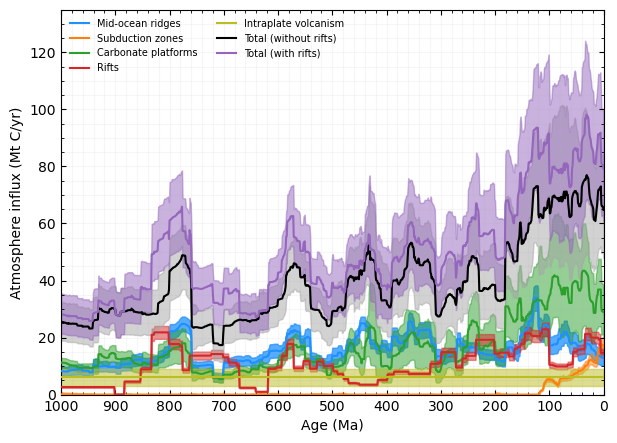

In [21]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Atmosphere influx (Mt C/yr)', xlim=[max_time,0])

# ridge outflux
ax.fill_between(reconstruction_times,
                ridge_outflux[:,0],
                ridge_outflux[:,2],
                color='dodgerblue', alpha=0.75, zorder=1)
ax.plot(reconstruction_times, ridge_outflux[:,1], c='dodgerblue', label='Mid-ocean ridges', zorder=3)

# subduction outflux
ax.fill_between(reconstruction_times,
                subduction_outflux[:,0]*constant_percentage_arr[0],
                subduction_outflux[:,2]*constant_percentage_arr[2],
                color='C1', alpha=0.5, zorder=1)
ax.plot(reconstruction_times, subduction_outflux[:,1]*constant_percentage_arr[1], c='C1', label='Subduction zones', zorder=3)

# carbonate platform degassing
ax.plot(reconstruction_times, carbonate_platform_outflux[:,1], c='C2', label='Carbonate platforms', zorder=3)
ax.fill_between(reconstruction_times,
                carbonate_platform_outflux[:,0],
                carbonate_platform_outflux[:,2],
                color='C2', alpha=0.5)

# rift degassing - bias-corrected (unbiased) rifts
ax.plot(reconstruction_times, mean_degassing, c='C3', label='Rifts', zorder=3)
ax.fill_between(reconstruction_times,
                min_degassing,
                max_degassing,
                color='C3', alpha=0.5)

# intraplate volcanism
ax.fill_between(reconstruction_times,
                intraplate_volcanism_outflux[:,0],
                intraplate_volcanism_outflux[:,2],
                color='C8', alpha=0.5, zorder=1)
ax.plot(reconstruction_times, intraplate_volcanism_outflux[:,1], c='C8', label='Intraplate volcanism', zorder=3)



ax.fill_between(reconstruction_times,
                total_atmosphere_influx[:,0],
                total_atmosphere_influx[:,2],
                color='0.65', alpha=0.5)
ax.plot(reconstruction_times, total_atmosphere_influx[:,1], c="k", label='Total (without rifts)')

ax.fill_between(reconstruction_times,
                total_atmosphere_influx[:,0]+min_degassing,
                total_atmosphere_influx[:,2]+max_degassing,
                color='C4', alpha=0.5)
ax.plot(reconstruction_times, total_atmosphere_influx[:,1]+mean_degassing, c="C4", label='Total (with rifts)')

ax.legend(frameon=False, loc='upper left', prop={'size': 7}, ncols=2)
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis="both", direction="in", which="both", right=True,top=True)
ax.grid(alpha=0.1, which='both')
ax.yaxis.set_ticks(np.arange(0., 135., 5.), minor=True)
ax.xaxis.set_ticks(np.arange(0., 1001., 20.), minor=True)
ax.xaxis.set_ticks(np.arange(0., 1001., 100.), major=True)

plt.ylim([0, 135])

fig.savefig(output_directory+"/figures/atmosphere_influx_comparison_sameaxes.pdf", bbox_inches='tight', dpi=600)
fig.savefig(output_directory+"/figures/atmosphere_influx_comparison_sameaxes.svg", bbox_inches='tight', dpi=600)
fig.savefig(output_directory+"/figures/atmosphere_influx_comparison_sameaxes.png", bbox_inches='tight', dpi=600)

### Compute mean, median and standard deviations for all atmospheric influx quantities (unbiased rifts)

In [22]:
print("Mean ridge_outflux: {} MtC/yr".format( np.mean(ridge_outflux[:,1])))
print("Median ridge_outflux: {} MtC/yr".format( np.median(ridge_outflux[:,1])))
print("Standard deviation of ridge_outflux: {} MtC/yr".format( np.std(ridge_outflux[:,1])))

print("Mean subduction_outflux: {} MtC/yr".format( np.mean(subduction_outflux[:,1]*constant_percentage_arr[1])))
print("Median subduction_outflux: {} MtC/yr".format( np.median(subduction_outflux[:,1]*constant_percentage_arr[1])))
print("Standard deviation of subduction_outflux: {} MtC/yr".format( np.std(subduction_outflux[:,1]*constant_percentage_arr[1])))

print("Mean carbonate_platform_outflux: {} MtC/yr".format( np.mean(carbonate_platform_outflux[:,1])))
print("Median carbonate_platform_outflux: {} MtC/yr".format( np.median(carbonate_platform_outflux[:,1])))
print("Standard deviation of carbonate_platform_outflux: {} MtC/yr".format( np.std(carbonate_platform_outflux[:,1])))

print("Mean corrected rift mean_degassing: {} MtC/yr".format( np.mean(mean_degassing)))
print("Median corrected rift mean_degassing: {} MtC/yr".format( np.median(mean_degassing)))
print("Standard deviation of corrected rift mean_degassing: {} MtC/yr".format( np.std(mean_degassing)))

print("Mean intraplate_volcanism_outflux: {} MtC/yr".format( np.mean(intraplate_volcanism_outflux[:,1])))
print("Median intraplate_volcanism_outflux: {} MtC/yr".format( np.median(intraplate_volcanism_outflux[:,1])))
print("Standard deviation of intraplate_volcanism_outflux: {} MtC/yr".format( np.std(intraplate_volcanism_outflux[:,1])))

print("Mean total_atmosphere_influx: {} MtC/yr".format( np.mean(total_atmosphere_influx[:,1])))
print("Median total_atmosphere_influx: {} MtC/yr".format( np.median(total_atmosphere_influx[:,1])))
print("Standard deviation of total_atmosphere_influx: {} MtC/yr".format( np.std(total_atmosphere_influx[:,1])))

print("Mean total_atmosphere_influx with corrected rifts: {} MtC/yr".format( np.mean(total_atmosphere_influx[:,1]+mean_degassing)))
print("Median total_atmosphere_influx with corrected rifts: {} MtC/yr".format( np.median(total_atmosphere_influx[:,1]+mean_degassing)))
print("Standard deviation of total_atmosphere_influx with corrected rifts: {} MtC/yr".format( np.std(total_atmosphere_influx[:,1]+mean_degassing)))

Mean ridge_outflux: 15.49122296734632 MtC/yr
Median ridge_outflux: 14.689149250802926 MtC/yr
Standard deviation of ridge_outflux: 5.179295247123082 MtC/yr
Mean subduction_outflux: 0.921431238440437 MtC/yr
Median subduction_outflux: 0.0 MtC/yr
Standard deviation of subduction_outflux: 2.8651653157112533 MtC/yr
Mean carbonate_platform_outflux: 16.724280335482977 MtC/yr
Median carbonate_platform_outflux: 13.992900850985686 MtC/yr
Standard deviation of carbonate_platform_outflux: 9.198049658035869 MtC/yr
Mean corrected rift mean_degassing: 10.514119125606257 MtC/yr
Median corrected rift mean_degassing: 9.929471526990495 MtC/yr
Standard deviation of corrected rift mean_degassing: 6.165121246916861 MtC/yr
Mean intraplate_volcanism_outflux: 6.0 MtC/yr
Median intraplate_volcanism_outflux: 6.0 MtC/yr
Standard deviation of intraplate_volcanism_outflux: 0.0 MtC/yr
Mean total_atmosphere_influx: 39.13693454126973 MtC/yr
Median total_atmosphere_influx: 34.880471215203386 MtC/yr
Standard deviation of

### Compute mean, median and standard deviations for all plate influx quantities

In [23]:
# plate influx - 10Myr median filtered
mean_sediments_influx    = plate_influx['sediments']['mean'].to_numpy()
mean_serpentinite_influx = plate_influx['serpentinite_total']['mean'].to_numpy()
mean_crust_influx        = plate_influx['crust']['mean'].to_numpy()
mean_lithosphere_influx        = plate_influx['lithosphere']['mean'].to_numpy()

mean_serpentinite_bending_influx = plate_influx['serpentinite_bending']['mean'].to_numpy()
mean_serpentinite_mor_influx = plate_influx['serpentinite_mor']['mean'].to_numpy()

mean_organic_sed_influx = plate_influx['organic_sediments']['mean'].to_numpy()
mean_total_influx = plate_influx['total_influx']['mean'].to_numpy()

print("mean_sediments_influx: {} MtC/yr".format(np.mean(mean_sediments_influx)))
print("median sediments_influx: {} MtC/yr".format(np.median(mean_sediments_influx)))
print("standard deviation of sediments_influx: {} MtC/yr".format(np.std(mean_sediments_influx)))

print("mean_serpentinite_influx: {} MtC/yr".format(np.mean(mean_serpentinite_influx)))
print("median serpentinite_influx: {} MtC/yr".format(np.median(mean_serpentinite_influx)))
print("standard deviation of serpentinite_influx: {} MtC/yr".format(np.std(mean_serpentinite_influx)))

print("mean_crust_influx: {} MtC/yr".format(np.mean(mean_crust_influx)))
print("median crust_influx: {} MtC/yr".format(np.median(mean_crust_influx)))
print("standard deviation of crust_influx: {} MtC/yr".format(np.std(mean_crust_influx)))

print("mean_lithosphere_influx: {} MtC/yr".format(np.mean(mean_lithosphere_influx)))
print("median lithosphere_influx: {} MtC/yr".format(np.median(mean_lithosphere_influx)))
print("standard deviation of lithosphere_influx: {} MtC/yr".format(np.std(mean_lithosphere_influx)))

print("mean_serpentinite_bending_influx: {} MtC/yr".format(np.mean(mean_serpentinite_bending_influx)))
print("median serpentinite_bending_influx: {} MtC/yr".format(np.median(mean_serpentinite_bending_influx)))
print("standard deviation of serpentinite_bending_influx: {} MtC/yr".format(np.std(mean_serpentinite_bending_influx)))

print("mean_serpentinite_mor_influx: {} MtC/yr".format(np.mean(mean_serpentinite_mor_influx)))
print("median serpentinite_mor_influx: {} MtC/yr".format(np.median(mean_serpentinite_mor_influx)))
print("standard deviation of serpentinite_mor_influx: {} MtC/yr".format(np.std(mean_serpentinite_mor_influx)))

print("mean_organic_sed_influx: {} MtC/yr".format(np.mean(mean_organic_sed_influx)))
print("median organic_sed_influx: {} MtC/yr".format(np.median(mean_organic_sed_influx)))
print("standard deviation of organic_sed_influx: {} MtC/yr".format(np.std(mean_organic_sed_influx)))

print("mean_total_influx: {} MtC/yr".format(np.mean(mean_total_influx)))
print("median total_influx: {} MtC/yr".format(np.median(mean_total_influx)))
print("standard deviation of total_influx: {} MtC/yr".format(np.std(mean_total_influx)))


mean_sediments_influx: 18.05857698452641 MtC/yr
median sediments_influx: 0.0 MtC/yr
standard deviation of sediments_influx: 48.734159755539416 MtC/yr
mean_serpentinite_influx: 7.983356351792307 MtC/yr
median serpentinite_influx: 8.124614399338512 MtC/yr
standard deviation of serpentinite_influx: 1.2312821182180704 MtC/yr
mean_crust_influx: 28.924363954189438 MtC/yr
median crust_influx: 27.534415811012597 MtC/yr
standard deviation of crust_influx: 8.79618486507589 MtC/yr
mean_lithosphere_influx: 13.62775643030175 MtC/yr
median lithosphere_influx: 12.813386156462006 MtC/yr
standard deviation of lithosphere_influx: 4.919010805038277 MtC/yr
mean_serpentinite_bending_influx: 7.438535697870157 MtC/yr
median serpentinite_bending_influx: 7.540123599724572 MtC/yr
standard deviation of serpentinite_bending_influx: 0.9976939955297656 MtC/yr
mean_serpentinite_mor_influx: 0.5550849396262579 MtC/yr
median serpentinite_mor_influx: 0.3553811496706746 MtC/yr
standard deviation of serpentinite_mor_influ

### As above, accounting for non corrected rifts (biased rifts)

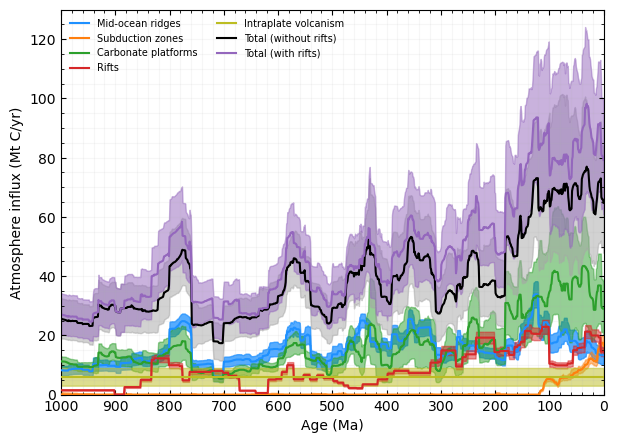

In [24]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Atmosphere influx (Mt C/yr)', xlim=[max_time,0])

# ridge outflux
ax.fill_between(reconstruction_times,
                ridge_outflux[:,0],
                ridge_outflux[:,2],
                color='dodgerblue', alpha=0.75, zorder=1)
ax.plot(reconstruction_times, ridge_outflux[:,1], c='dodgerblue', label='Mid-ocean ridges', zorder=3)

# subduction outflux
ax.fill_between(reconstruction_times,
                subduction_outflux[:,0]*constant_percentage_arr[0],
                subduction_outflux[:,2]*constant_percentage_arr[2],
                color='C1', alpha=0.5, zorder=1)
ax.plot(reconstruction_times, subduction_outflux[:,1]*constant_percentage_arr[1], c='C1', label='Subduction zones', zorder=3)

# carbonate platform degassing
ax.plot(reconstruction_times, carbonate_platform_outflux[:,1], c='C2', label='Carbonate platforms', zorder=3)
ax.fill_between(reconstruction_times,
                carbonate_platform_outflux[:,0],
                carbonate_platform_outflux[:,2],
                color='C2', alpha=0.5)

# rift degassing - biased (not corrected) rifts
ax.plot(reconstruction_times, mean_degassing_non_corrected, c='C3', label='Rifts', zorder=3)
ax.fill_between(reconstruction_times,
                min_degassing_non_corrected,
                max_degassing_non_corrected,
                color='C3', alpha=0.5)

# intraplate volcanism
ax.fill_between(reconstruction_times,
                intraplate_volcanism_outflux[:,0],
                intraplate_volcanism_outflux[:,2],
                color='C8', alpha=0.5, zorder=1)
ax.plot(reconstruction_times, intraplate_volcanism_outflux[:,1], c='C8', label='Intraplate volcanism', zorder=3)


# Total atmosphere influx without rift degassing
ax.fill_between(reconstruction_times,
                total_atmosphere_influx[:,0],
                total_atmosphere_influx[:,2],
                color='0.65', alpha=0.5)
ax.plot(reconstruction_times, total_atmosphere_influx[:,1], c="k", label='Total (without rifts)')


# Total atmosphere influx WITH rift degassing - NON-BIAS-CORRECTED (biased) RIFTS
ax.fill_between(reconstruction_times,
                total_atmosphere_influx[:,0]+min_degassing_non_corrected,
                total_atmosphere_influx[:,2]+max_degassing_non_corrected,
                color='C4', alpha=0.5)
ax.plot(reconstruction_times, total_atmosphere_influx[:,1]+mean_degassing_non_corrected, c="C4", label='Total (with rifts)')


ax.legend(frameon=False, loc='upper left', prop={'size': 7}, ncols=2)
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis="both", direction="in", which="both", right=True, top=True)
ax.grid(alpha=0.1, which='both')
ax.yaxis.set_ticks(np.arange(0., 130., 5.), minor=True)
ax.xaxis.set_ticks(np.arange(0., 1001., 20.), minor=True)
ax.xaxis.set_ticks(np.arange(0., 1001., 100.), major=True)

plt.ylim([0, 130])

fig.savefig(output_directory+"/figures/atmosphere_influx_comparison_non_corrected_sameaxes.pdf", bbox_inches='tight', dpi=600)
fig.savefig(output_directory+"/figures/atmosphere_influx_comparison_non_corrected_sameaxes.svg", bbox_inches='tight', dpi=600)
fig.savefig(output_directory+"/figures/atmosphere_influx_comparison_non_corrected_sameaxes.png", bbox_inches='tight', dpi=600)

### Replacing continental arc degassing above with Ratschbacher et al. continental arc degassing
The dataset is digitised in 3 different text files and must be interpolated into 1Myr intervals

Text(0.5, 1.0, 'Interpolating Ratschbacher data into 1Myr intervals')

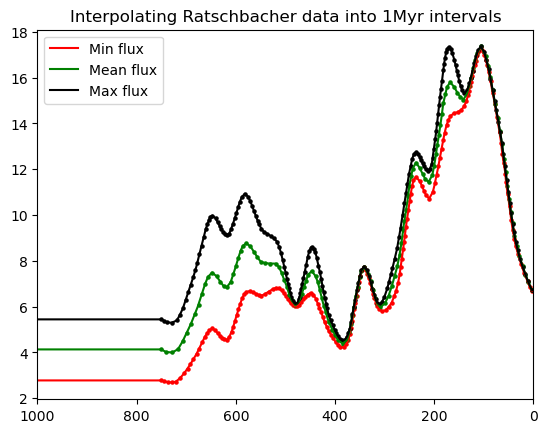

In [25]:
exts = ["_min", "", "_max"]
#fname = "./utils/Re_arcs/Ratschbacher2019-fig4_arc_CO2{}.txt"
fname = "./utils/Re_arcs/Ratschbacher2019-fig4_arc_CO2{}.txt"

min_Ratschbacher = pd.read_table(fname.format(exts[0]))
mean_Ratschbacher = pd.read_table(fname.format(exts[1]))
max_Ratschbacher = pd.read_table(fname.format(exts[2]))

Ratschbacher_min_time = min_Ratschbacher['> Age (Ma)'].to_numpy()
Ratschbacher_mean_time = mean_Ratschbacher['> Age (Ma)'].to_numpy()
Ratschbacher_max_time  = max_Ratschbacher['> Age (Ma)'].to_numpy()

min_flux = min_Ratschbacher['Min Global CO2 flux from cont. arcs (Mt C/yr)'].to_numpy()
mean_flux = mean_Ratschbacher['Global CO2 flux from cont. arcs (Mt C/yr)'].to_numpy()
max_flux = max_Ratschbacher['Max Global CO2 flux from cont. arcs (Mt C/yr)'].to_numpy()

# Sort x and obtain the indices that would sort x
sorted_min = np.argsort(Ratschbacher_min_time)
sorted_mean = np.argsort(Ratschbacher_mean_time)
sorted_max = np.argsort(Ratschbacher_max_time)

# Reorder x and y based on the sorted indices
sorted_min_time = Ratschbacher_min_time[sorted_min]
sorted_min_flux = min_flux[sorted_min]
sorted_mean_time = Ratschbacher_mean_time[sorted_mean]
sorted_mean_flux = mean_flux[sorted_mean]
sorted_max_time = Ratschbacher_max_time[sorted_max]
sorted_max_flux = max_flux[sorted_max]

new_time = np.arange(0, 751, 1)
new_min_flux = np.interp(new_time, sorted_min_time, sorted_min_flux)

new_mean_time = np.arange(min(sorted_mean_time), max(sorted_mean_time), 1)
new_mean_flux = np.interp(new_time, sorted_mean_time, sorted_mean_flux)

new_max_time = np.arange(min(sorted_max_time), max(sorted_max_time), 1)
new_max_flux = np.interp(new_time, sorted_max_time, sorted_max_flux)


ratschbacher_flux = np.zeros((len(reconstruction_times),3))
ratschbacher_flux[:751,0] = new_min_flux
ratschbacher_flux[:751,1] = new_mean_flux
ratschbacher_flux[:751,2] = new_max_flux
ratschbacher_flux[751:,:] = ratschbacher_flux[750,:]

plt.scatter(Ratschbacher_min_time, min_flux, color='r', s=5)
plt.plot(reconstruction_times, ratschbacher_flux[:,0], color='r', label="Min flux")

plt.scatter(Ratschbacher_mean_time, mean_flux, color='g', s=5)
plt.plot(reconstruction_times, ratschbacher_flux[:,1], color='g', label="Mean flux")

plt.scatter(Ratschbacher_max_time, max_flux, color='k', s=5)
plt.plot(reconstruction_times, ratschbacher_flux[:,2], color='k', label="Max flux")

plt.xlim([1000,0])
plt.legend()

plt.title("Interpolating Ratschbacher data into 1Myr intervals")

### Plotting comparisons of Ratschbacher continental arc degassing to carbonate platform degassing, and how they contribute to the total atmosphere influx **noting these consider non-biased rifts**.

In [26]:

total_atmosphere_influx_ratschbacher = ridge_outflux + subduction_atmosphere_influx + ratschbacher_flux + intraplate_volcanism_outflux


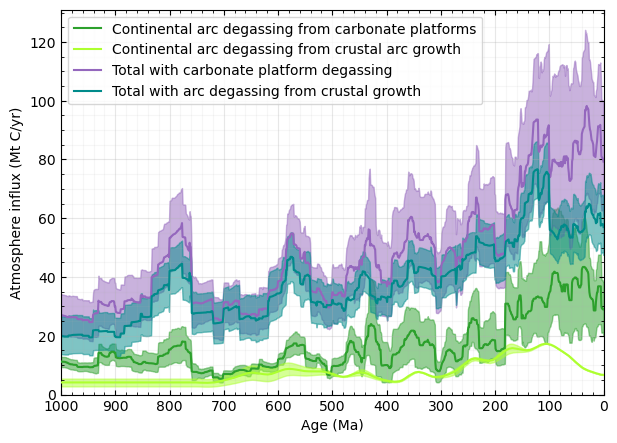

In [27]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Atmosphere influx (Mt C/yr)',)

# carbonate platform degassing
ax.plot(reconstruction_times, carbonate_platform_outflux[:,1], c='C2', label='Continental arc degassing from carbonate platforms', zorder=3)
ax.fill_between(reconstruction_times,
                carbonate_platform_outflux[:,0],
                carbonate_platform_outflux[:,2],
                color='C2', alpha=0.5)

ax.plot(reconstruction_times, ratschbacher_flux[:,1], c='greenyellow', label='Continental arc degassing from crustal arc growth', zorder=3)
ax.fill_between(reconstruction_times,
                ratschbacher_flux[:,0],
                ratschbacher_flux[:,2],
                color='greenyellow', alpha=0.5)

# Total atmosphere influx WITH rift degassing - NON-CORRECTED (BIASED) RIFTS
ax.fill_between(reconstruction_times,
                total_atmosphere_influx[:,0]+min_degassing_non_corrected,
                total_atmosphere_influx[:,2]+max_degassing_non_corrected,
                color='C4', alpha=0.5)
ax.plot(reconstruction_times, total_atmosphere_influx[:,1]+mean_degassing_non_corrected, c="C4", label='Total with carbonate platform degassing')


# Total atmosphere influx WITH rift degassing - NON-CORRECTED (BIASED) RIFTS - Using Ratschbacher carbonate platform degassing
ax.fill_between(reconstruction_times,
                total_atmosphere_influx_ratschbacher[:,0]+min_degassing_non_corrected,
                total_atmosphere_influx_ratschbacher[:,2]+max_degassing_non_corrected,
                color='darkcyan', alpha=0.5)
ax.plot(reconstruction_times, total_atmosphere_influx_ratschbacher[:,1]+mean_degassing_non_corrected, c="darkcyan", label='Total with arc degassing from crustal growth')


ax.set_xlim([max_time, min_time])
ax.set_ylim([0,131])

ax.grid(alpha=0.1, which='both')
ax.grid(alpha=0.3, which='major')
ax.yaxis.set_ticks(np.arange(0., 131., 5.), minor=True)
ax.xaxis.set_ticks(np.arange(0., 1001., 20.), minor=True)
ax.xaxis.set_ticks(np.arange(0., 1001., 100.), major=True)
ax.tick_params(axis="both", direction="in", which="both", right=True, top=True)

ax.legend(loc='upper left')


fig.savefig(output_directory+"/figures/continental_arc_degassing_comparison_non_corrected_sameaxes.pdf", bbox_inches='tight', dpi=600)
fig.savefig(output_directory+"/figures/continental_arc_degassing_comparison_non_corrected_sameaxes.svg", bbox_inches='tight', dpi=600)
fig.savefig(output_directory+"/figures/continental_arc_degassing_comparison_non_corrected_sameaxes.png", bbox_inches='tight', dpi=600)

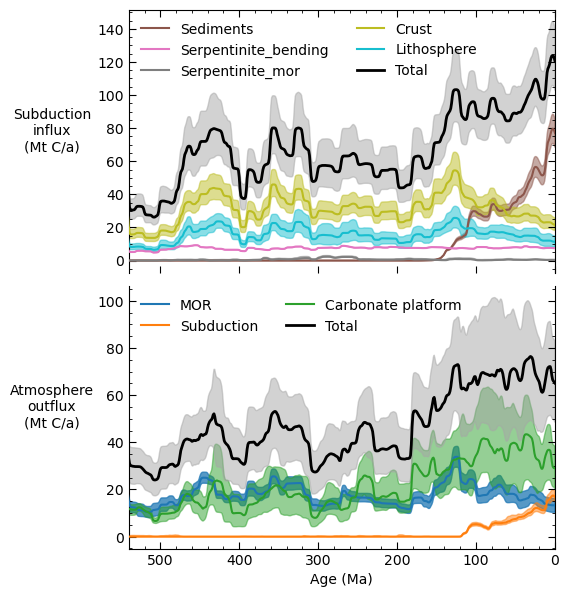

In [28]:
from scipy import ndimage

def smooth(array, sigma=1):
    return ndimage.gaussian_filter1d(array, sigma)

fig = plt.figure(figsize=(5.5,7))
ax1 = fig.add_subplot(2,1,1, xlim=[540,0])

for c, label in enumerate(['sediments', 'serpentinite_bending', 'serpentinite_mor', 'crust', 'lithosphere']):
    ax1.fill_between(reconstruction_times,
                    smooth(subduction_influx[label]["min"]),
                    smooth(subduction_influx[label]["max"]),
                    color='C{}'.format(c+5), alpha=0.5, zorder=1)
    ax1.plot(reconstruction_times, smooth(subduction_influx[label]["mean"]), c='C{}'.format(c+5),
            label=label.capitalize(), zorder=3)

ax1.fill_between(reconstruction_times,
                smooth(subduction_influx['total']["min"]),
                smooth(subduction_influx['total']["max"]),
                color='0.65', alpha=0.5, zorder=1)
ax1.plot(reconstruction_times, smooth(subduction_influx['total']["mean"]), c='k', linewidth=2,
        label="Total", zorder=3)

ax1.set_ylabel('Subduction\ninflux\n(Mt C/a)', rotation='horizontal')
ax1.yaxis.set_label_coords(-0.18, 0.45)
ax1.tick_params(direction="in", which='major', length=5,   bottom=True, top=True, right=True)
ax1.tick_params(direction='in', which='minor', length=2.5, bottom=False, top=True, right=True)
ax1.minorticks_on()
ax1.set_xticklabels([])
ax1.legend(ncol=2, loc='upper left', frameon=False)
ax1.spines['bottom'].set_visible(False)

ax = fig.add_subplot(2,1,2, xlabel='Age (Ma)', xlim=[540,0])


ax.set_ylabel('Atmosphere\noutflux\n(Mt C/a)', rotation='horizontal')
ax.yaxis.set_label_coords(-0.18, 0.45)
ax.tick_params(direction="in", which='major', length=5,   top=False, right=True)
ax.tick_params(direction='in', which='minor', length=2.5, top=False, right=True)
ax.minorticks_on()

# ridge outflux
ax.fill_between(reconstruction_times,
                smooth(ridge_outflux[:,0]),
                smooth(ridge_outflux[:,2]),
                color='C0', alpha=0.75, zorder=1)
ax.plot(reconstruction_times, smooth(ridge_outflux[:,1]), c='C0',
        label='MOR', zorder=3)

# subduction outflux
ax.fill_between(reconstruction_times,
                smooth(subduction_outflux[:,0]*constant_percentage_arr[0]),
                smooth(subduction_outflux[:,2]*constant_percentage_arr[2]),
                color='C1', alpha=0.5, zorder=1)
ax.plot(reconstruction_times, smooth(subduction_outflux[:,1]*constant_percentage_arr[1]),
        c='C1', label='Subduction', zorder=3)

# carbonate platform degassing
ax.fill_between(reconstruction_times,
                smooth(carbonate_platform_outflux[:,0]),
                smooth(carbonate_platform_outflux[:,2]),
                color='C2', alpha=0.5)
ax.plot(reconstruction_times, smooth(carbonate_platform_outflux[:,1]),
        c='C2', label='Carbonate platform', zorder=3)

# total
ax.fill_between(reconstruction_times,
                smooth(total_atmosphere_influx[:,0]),
                smooth(total_atmosphere_influx[:,2]),
                color='0.65', alpha=0.5)
ax.plot(reconstruction_times, smooth(total_atmosphere_influx[:,1]),
        c="k", linewidth=2, label='Total')

ax.legend(frameon=False, loc='upper left', ncol=2, )
ax.spines['top'].set_visible(False)

fig.subplots_adjust(hspace=0.05)

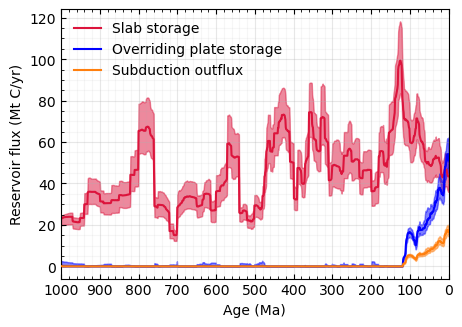

In [29]:
fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Reservoir flux (Mt C/yr)',)

ax.set_xlim([max_time, min_time])

# total atmospheric flux 
# ax.fill_between(reconstruction_times,
#                total_atmosphere_influx[:,0],
#                total_atmosphere_influx[:,2],
#                color='0.5', alpha=0.5)

# ax.plot(reconstruction_times, total_atmosphere_influx[:,1], c="k", label='Atmosphere')

# Decarbonation into convecting mantle
ax.fill_between(reconstruction_times,
                plate_storage[:,0],
                plate_storage[:,2],
                color='crimson', alpha=0.5)
ax.plot(reconstruction_times, plate_storage[:,1], c="crimson", label='Slab storage')

# Storage in overriding plate (C8)
ax.fill_between(reconstruction_times,
                overriding_plate_storage[:,0],
                overriding_plate_storage[:,2],
                color='blue', alpha=0.5)
ax.plot(reconstruction_times, overriding_plate_storage[:,1], c="blue", label='Overriding plate storage')

# subduction outflux
ax.fill_between(reconstruction_times,
                subduction_outflux[:,0]*constant_percentage_arr[0],
                subduction_outflux[:,2]*constant_percentage_arr[2],
                color='C1', alpha=0.5, zorder=1)
ax.plot(reconstruction_times, subduction_outflux[:,1]*constant_percentage_arr[1], c='C1', label='Subduction outflux', zorder=3)
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)

ax.xaxis.set_ticks(np.arange(0., 1001., 20.), minor=True)
ax.xaxis.set_ticks(np.arange(0., 1001., 100.), major=True)
ax.yaxis.set_ticks(np.arange(0., 121., 5.), minor=True)
    
ax.legend(frameon=False, loc='upper left')
ax.grid(alpha=0.1, which='minor')
ax.grid(alpha=0.3, which='major')

fig.savefig(output_directory+"reservoir_flux.pdf", bbox_inches='tight', dpi=600)
fig.savefig(output_directory+"reservoir_flux.svg", bbox_inches='tight', dpi=600)
fig.savefig(output_directory+"reservoir_flux.png", bbox_inches='tight', dpi=600)

### Net atmospheric influx

The plate influx minus total atmospheric influx - using the unbiased (corrected) rifts

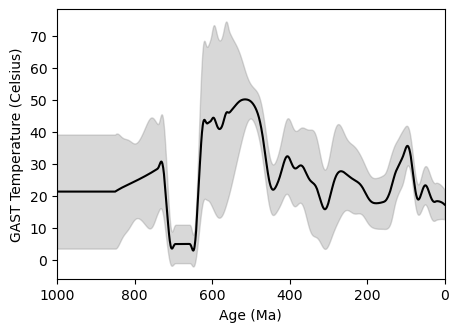

In [30]:
global_temp_evolution_pd = pd.read_excel("./utils/GAST_1000Ma.xlsx")

GAST_times = global_temp_evolution_pd["Time (Ma)"].to_numpy()[::-1]*-1
GAST_min = global_temp_evolution_pd["GAST (min)"].to_numpy()[::-1]
GAST_max = global_temp_evolution_pd["GAST (max)"].to_numpy()[::-1]
GAST_mean = (GAST_min + GAST_max)/2

# Remove artificial errorbars from 850-1000Ma.
for t, temp in enumerate(GAST_min):
    if t > 850:
        GAST_min[t] = GAST_min[850]
        GAST_max[t] = GAST_max[850]
        GAST_mean[t] = GAST_mean[850]

fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='GAST Temperature (Celsius)',)

ax.set_xlim([max_time, min_time])

ax.fill_between(reconstruction_times,
                GAST_min,
                GAST_max,
                color='0.5', alpha=0.3, zorder=1)
ax.plot(reconstruction_times, GAST_mean, c='k', label='Mills')


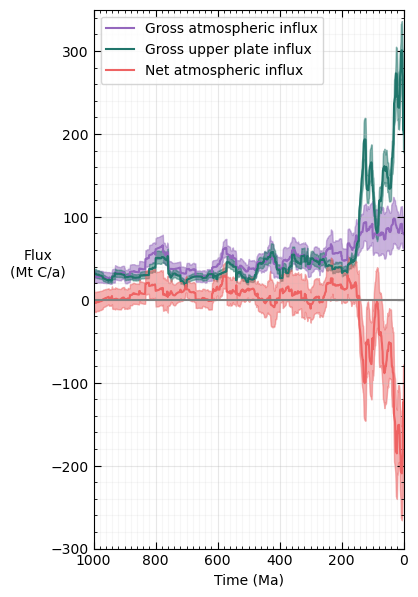

In [31]:
# plate influx
upper_plate_influx = sediments_influx + serpentinite_influx + crust_influx

# Add rift outgassing to the total atmosphere flux defined in earlier cells for min, mean and max (UNBIASED)
total_atmospheric_influx_with_rifts = np.zeros((len(reconstruction_times), 3))
total_atmospheric_influx_with_rifts[:,0] = total_atmosphere_influx[:,0]+min_degassing
total_atmospheric_influx_with_rifts[:,1] = total_atmosphere_influx[:,1]+mean_degassing
total_atmospheric_influx_with_rifts[:,2] = total_atmosphere_influx[:,2]+max_degassing

# Determine the upper and lower uncertainty in gross atmospheric influx by subtracting the mean from the max,
# and the min from the mean.
upper_uncertainty_gross_atmospheric_influx = total_atmospheric_influx_with_rifts[:,2] - total_atmospheric_influx_with_rifts[:,1]
lower_uncertainty_gross_atmospheric_influx = total_atmospheric_influx_with_rifts[:,1] - total_atmospheric_influx_with_rifts[:,0]
# Repeat for upper plate influx
upper_uncertainty_gross_upper_plate_influx = upper_plate_influx[:,2] - upper_plate_influx[:,1]
lower_uncertainty_gross_upper_plate_influx = upper_plate_influx[:,1] - upper_plate_influx[:,0]
# Get total uncertainty by summing the uncertainties for gross atmospheric influx and plate influx.
total_upper_uncertainty = upper_uncertainty_gross_atmospheric_influx + upper_uncertainty_gross_upper_plate_influx
total_lower_uncertainty = lower_uncertainty_gross_atmospheric_influx + lower_uncertainty_gross_upper_plate_influx

# Net atmospheric influx is total atmospheric influx minus upper plate influx. Get the mean for now
mean_net_atmospheric_influx = total_atmospheric_influx_with_rifts[:,1] - upper_plate_influx[:,1]

# The min and max is the mean - lower uncertainty and mean + upper uncertainty respectively
min_net_atmospheric_influx = mean_net_atmospheric_influx - total_lower_uncertainty 
max_net_atmospheric_influx = mean_net_atmospheric_influx + total_upper_uncertainty


# PRODUCE THE PLOT
fig = plt.figure(figsize=(4, 7))
ax = fig.add_subplot(1,1,1)


# Gross atmospheric influx
ax.fill_between(reconstruction_times,
                total_atmospheric_influx_with_rifts[:,0],
                total_atmospheric_influx_with_rifts[:,2],
                color='C4', alpha=0.5)
ax.plot(reconstruction_times, total_atmospheric_influx_with_rifts[:,1], c="C4", label="Gross atmospheric influx")


# Gross plate influx 
ax.fill_between(reconstruction_times,
                upper_plate_influx[:,0],
                upper_plate_influx[:,2],
                color='#20756b', alpha=0.5)
ax.plot(reconstruction_times, upper_plate_influx[:,1], c="#20756b", label="Gross upper plate influx")

# Overall difference
ax.fill_between(reconstruction_times,
                min_net_atmospheric_influx,
                max_net_atmospheric_influx,
                color='#EE6363', alpha=0.5)
ax.plot(reconstruction_times, mean_net_atmospheric_influx, c="#EE6363", label="Net atmospheric influx")
ax.yaxis.set_label_coords(-0.18, 0.45)

ax.tick_params(direction="in", which='major', length=5,   bottom=True, top=True, right=True)
ax.tick_params(direction='in', which='minor', length=2.5, bottom=False, top=True, right=True)

ax.tick_params(axis='x', which='minor', bottom=True)
ax.xaxis.set_ticks(np.arange(1000, 0, -20.),minor=True, bottom=True)
ax.spines['bottom'].set_visible(True)
ax.set_xlabel("Time (Ma)")


# Partition net outflux and net influx
ax.plot(reconstruction_times, np.zeros(len(reconstruction_times),), color='0.5')

ax.xaxis.set_ticks(np.arange(1000, 0, -20.),minor=True)
ax.yaxis.set_ticks(np.arange(-300,350, 20.),minor=True)

ax.grid(alpha=0.1, which='both')
ax.grid(alpha=0.3, which='major')
ax.legend(loc='upper left')


ax.set_xlim([max_time, min_time])
ax.set_ylim([-300,350])
ax.set_ylabel('Flux\n(Mt C/a)', rotation='horizontal')

fig.savefig(output_directory+"/figures/net_atmospheric_influx.pdf", bbox_inches='tight', dpi=600)
fig.savefig(output_directory+"/figures/net_atmospheric_influx.svg", bbox_inches='tight', dpi=600)
fig.savefig(output_directory+"/figures/net_atmospheric_influx.png", bbox_inches='tight', dpi=600)


Note the figure above considers carbon in sediments for upper plate influx, and the bias-preservation (UNBIASED) corrected rift length for rift outgassing.

In [32]:
# Save the data from the plot above to csv
data_out = np.column_stack(
    (
    total_atmospheric_influx_with_rifts,
    upper_plate_influx,
    min_net_atmospheric_influx,
    mean_net_atmospheric_influx,
    max_net_atmospheric_influx
    )
)

# All unbiased, as we use the rifts scaled by the multiplier
headers = [
    "gross_atmospheric_influx_with_unbiased_rifts",
    "gross_plate_influx_with_sed_unbiased_rifts",
    "net_atmospheric_influx_with_sed_unbiased_rifts"
]

quantiles = ['min', 'mean', 'max']
index = pd.MultiIndex.from_product([headers, quantiles])
df_atmospheric_influx = pd.DataFrame(list(data_out), columns = index, index=reconstruction_times) 
df_atmospheric_influx.to_csv(output_directory+"/csv/05_net_atmospheric_influx.csv", index_label='Age (Ma)')

### Repeat calculation of net atmospheric influx using NON-CORRECTED (biased) rift lengths, still including sediments 

In [33]:
# Prepare atmospheric influx based on non-bias corrected (biased) rifts
total_atmospheric_influx_with_biased_rifts = np.zeros((len(reconstruction_times), 3))
total_atmospheric_influx_with_biased_rifts[:,0] = total_atmosphere_influx[:,0]+min_degassing_non_corrected
total_atmospheric_influx_with_biased_rifts[:,1] = total_atmosphere_influx[:,1]+mean_degassing_non_corrected
total_atmospheric_influx_with_biased_rifts[:,2] = total_atmosphere_influx[:,2]+max_degassing_non_corrected

# Uncertainty in gross atmospheric influx is the max outflux minus mean (upper), and mean minus min (lower)
upper_uncertainty_gross_atmospheric_influx_biased = total_atmospheric_influx_with_biased_rifts[:,2] - total_atmospheric_influx_with_biased_rifts[:,1]
lower_uncertainty_gross_atmospheric_influx_biased = total_atmospheric_influx_with_biased_rifts[:,1] - total_atmospheric_influx_with_biased_rifts[:,0]

# OVERALL UNCERTAINTY - Still using sediment, and gross atm influx uses biased rifts
total_upper_uncertainty_biased = upper_uncertainty_gross_atmospheric_influx_biased + upper_uncertainty_gross_upper_plate_influx
total_lower_uncertainty_biased = lower_uncertainty_gross_atmospheric_influx_biased + lower_uncertainty_gross_upper_plate_influx

# Net carbon outflux is gross atmospheric - gross upper plate (which includes sediments here, and involves non-bias corrected (biased) rifts)
mean_net_atmospheric_influx_biased_with_sed = total_atmospheric_influx_with_biased_rifts[:,1] - upper_plate_influx[:,1]
min_net_atmospheric_influx_biased_with_sed = mean_net_atmospheric_influx_biased_with_sed - total_lower_uncertainty_biased 
max_net_atmospheric_influx_biased_with_sed = mean_net_atmospheric_influx_biased_with_sed + total_upper_uncertainty_biased

In [34]:
# Save the data from "atmosphere_influx_comparison_sameaxes" to csv - consider both cases of rift degassing
# i.e. with and without preservation bias correction

data_out = [
    reconstruction_times,
    ridge_outflux,
    subduction_outflux[:,0]*constant_percentage_arr[0],
    subduction_outflux[:,1]*constant_percentage_arr[1],
    subduction_outflux[:,2]*constant_percentage_arr[2],
    carbonate_platform_outflux,
    
    # Rift degassing with bias-correction (non-biased)
    min_degassing,
    mean_degassing,
    max_degassing,
    
    # Rift degassing without bias-correction (biased rifts)
    min_degassing_non_corrected,
    mean_degassing_non_corrected,
    max_degassing_non_corrected,
    
    
    intraplate_volcanism_outflux,
    
    # Total atmospheric influx WITHOUT rift degassing
    total_atmosphere_influx,
    
    # Total atmospheric influx with bias-corrected rift outgassing (unbiased)
    total_atmosphere_influx[:,0]+min_degassing,  #total_atmospheric_influx_with_rifts[:,0]
    total_atmosphere_influx[:,1]+mean_degassing,  #total_atmospheric_influx_with_rifts[:,1]
    total_atmosphere_influx[:,2]+max_degassing,  #total_atmospheric_influx_with_rifts[:,2]
    
    # Total atmospheric influx with raw, uncorrected rift outgassing (biased)
    total_atmosphere_influx[:,0]+min_degassing_non_corrected,  #total_atmospheric_influx_with_biased_rifts[:,0]
    total_atmosphere_influx[:,1]+mean_degassing_non_corrected,  #total_atmospheric_influx_with_biased_rifts[:,1]
    total_atmosphere_influx[:,2]+max_degassing_non_corrected,  #total_atmospheric_influx_with_biased_rifts[:,2]
    
    # Net atmopsheric influx with bias-corrected rift outgassing (unbiased), and sediment
    min_net_atmospheric_influx,
    mean_net_atmospheric_influx, #total_atmospheric_influx_with_rifts[:,1] - upper_plate_influx[:,1]
    max_net_atmospheric_influx,
    
    # Net atmopsheric influx with raw, uncorrected rift outgassing (biased), and sediment
    min_net_atmospheric_influx_biased_with_sed,
    mean_net_atmospheric_influx_biased_with_sed,
    max_net_atmospheric_influx_biased_with_sed,
    
    # Gross upper plate influx (Sed + serpentinite + crust)
    upper_plate_influx
]


headers = ['time',
           
           'ridge_outflux_min',
           'ridge_outflux_mean',
           'ridge_outflux_max',
           
           'subduction_outflux_min',
           'subduction_outflux_mean',
            'subduction_outflux_max',
           
            'carbonate_platform_outflux_min',
            'carbonate_platform_outflux_mean',
            'carbonate_platform_outflux_max',
           
            'rift_outflux_non_biased_min',
            'rift_outflux_non_biased_mean',
            'rift_outflux_non_biased_max',
           
            'rift_outflux_biased_min',
            'rift_outflux_biased_mean',
            'rift_outflux_biased_max',
           
            'intraplate_volcanism_outflux_min',
            'intraplate_volcanism_outflux_mean',
            'intraplate_volcanism_outflux_max',
           
           'gross_atmospheric_influx_no_rift_min',
            'gross_atmospheric_influx_no_rift_mean',
            'gross_atmospheric_influx_no_rift_max',
           
           'gross_atmospheric_influx_unbiased_rift_min',
            'gross_atmospheric_influx_unbiased_rift_mean',
            'gross_atmospheric_influx_unbiased_rift_max',
           
           'gross_atmospheric_influx_biased_rift_min',
            'gross_atmospheric_influx_biased_rift_mean',
            'gross_atmospheric_influx_biased_rift_max',
           
           'net_atmospheric_influx_unbiased_and_sed_min',
           'net_atmospheric_influx_unbiased_and_sed_mean',
           'net_atmospheric_influx_unbiased_and_sed_max',
           
           'net_atmospheric_influx_biased_and_sed_min',
           'net_atmospheric_influx_biased_and_sed_mean',
           'net_atmospheric_influx_biased_and_sed_max',
           
           'gross_upper_plate_influx_with_sed_min', 
           'gross_upper_plate_influx_with_sed_mean', 
           'gross_upper_plate_influx_with_sed_max', 
          ]

df_outflux = pd.DataFrame(np.column_stack(data_out), columns=headers, index=reconstruction_times)
df_outflux.to_csv(output_directory+"/csv/05_atmospheric_influx_all_sources.csv", index_label='Age (Ma)')

## Repeat the analysis without the sediment reservoir
This will involve considering a total outflux excluding sediment.

In [35]:
# Global temperature evolution
scotese_gast = pd.read_excel("./utils/GAST_800Ma_Scotese.xlsx")
scotese_time = scotese_gast["Age (Ma)"].to_numpy()
scotese_temp = scotese_gast["GAST (deg C) Scotese"].to_numpy()

print("Minimum: ", subduction_outflux_no_sediment[0][0], " Mt C/yr")
print("Mean: ", subduction_outflux_no_sediment[0][1], " Mt C/yr")
print("Maximum: ", subduction_outflux_no_sediment[0][2], " Mt C/yr")

Minimum:  0.0  Mt C/yr
Mean:  0.0  Mt C/yr
Maximum:  1.5937108230738204  Mt C/yr


### First, consider total atmospheric influx using unbiased (corrected) rifts

In [36]:
# From 90-0Ma, subtract sediment storage from 

sed_storage_pd = pd.read_table("./utils/sediment_storage_5-15pc.txt", skiprows=7)
sed_storage_pd.columns = ['time', 'min', 'mean', 'max']

sed_storage_time=sed_storage_pd['time'].to_numpy()
sed_storage_min=sed_storage_pd['min'].to_numpy()
sed_storage_mean=sed_storage_pd['mean'].to_numpy()
sed_storage_max=sed_storage_pd['max'].to_numpy()


In [37]:
# CELL TO CALCULATE NET OUTFLUX WITHOUT SEDIMENT
# First, we use the unbiased rift lengths...

# Arrays for the upper and lower uncertainty in gross atmospheric influx
#upper_uncertainty_gross_atmospheric_influx = total_atmospheric_influx_with_rifts[:,2] - total_atmospheric_influx_with_rifts[:,1]
#lower_uncertainty_gross_atmospheric_influx = total_atmospheric_influx_with_rifts[:,1] - total_atmospheric_influx_with_rifts[:,0]

# Arrays for the upper and lower uncertainty in gross upper plate influx (WITHOUT SEDIMENT)
upper_uncertainty_gross_upper_plate_influx_no_sediment = upper_plate_influx_no_sediment[:,2] - upper_plate_influx_no_sediment[:,1]
lower_uncertainty_gross_upper_plate_influx_no_sediment = upper_plate_influx_no_sediment[:,1] - upper_plate_influx_no_sediment[:,0]

# Add all uncertainty arrays to propagate overall uncertainty for the net outflux
total_upper_uncertainty_no_sed = upper_uncertainty_gross_atmospheric_influx + upper_uncertainty_gross_upper_plate_influx_no_sediment
total_lower_uncertainty_no_sed = lower_uncertainty_gross_atmospheric_influx + lower_uncertainty_gross_upper_plate_influx_no_sediment

# Net outflux arrays: Min is mean minus lower uncertainty, and max is mean plus upper uncertainty
mean_net_atmospheric_influx_no_sed = total_atmospheric_influx_with_rifts[:,1] - upper_plate_influx_no_sediment[:,1]
min_net_atmospheric_influx_no_sed = mean_net_atmospheric_influx_no_sed - total_lower_uncertainty_no_sed
max_net_atmospheric_influx_no_sed = mean_net_atmospheric_influx_no_sed + total_upper_uncertainty_no_sed


min_net_atmospheric_influx_with_sediment_storage = min_net_atmospheric_influx_no_sed.copy()
mean_net_atmospheric_influx_with_sediment_storage = mean_net_atmospheric_influx_no_sed.copy()
max_net_atmospheric_influx_with_sediment_storage = max_net_atmospheric_influx_no_sed.copy()

min_net_atmospheric_influx_with_sediment_storage[:91] = min_net_atmospheric_influx_with_sediment_storage[:91] - sed_storage_min
mean_net_atmospheric_influx_with_sediment_storage[:91] = mean_net_atmospheric_influx_with_sediment_storage[:91] - sed_storage_mean
max_net_atmospheric_influx_with_sediment_storage[:91] = max_net_atmospheric_influx_with_sediment_storage[:91] - sed_storage_max


# NOTE: THIS IS THE RATIO OF ATMOSPHERIC TO UPPER plate influx, **INCLUDING** SEDIMENT AND WITH UNBIASED RIFTS
# Ratio of atmospheric to upper plate, WITH sediment
gross_outflux_to_gross_influx_with_rifts = total_atmospheric_influx_with_rifts/upper_plate_influx

# Using uncertainty propagation for division to get upper uncertainty
total_upper_ratio_uncertainty = np.abs(gross_outflux_to_gross_influx_with_rifts[:,1]) * np.sqrt(

    (upper_uncertainty_gross_atmospheric_influx/total_atmospheric_influx_with_rifts[:,1])**2 +
    (upper_uncertainty_gross_upper_plate_influx/upper_plate_influx[:,1])**2
)
# Using uncertainty propagation for division to get lower uncertainty
total_lower_ratio_uncertainty = np.abs(gross_outflux_to_gross_influx_with_rifts[:,1]) * np.sqrt(

    (lower_uncertainty_gross_atmospheric_influx/total_atmospheric_influx_with_rifts[:,1])**2 +
    (lower_uncertainty_gross_upper_plate_influx/upper_plate_influx[:,1])**2
)

# Min, mean and max ratio of outfluxes.
mean_gross_outflux_to_gross_influx_with_rifts = total_atmospheric_influx_with_rifts[:,1]/upper_plate_influx[:,1]
min_gross_outflux_to_gross_influx_with_rifts = mean_gross_outflux_to_gross_influx_with_rifts - total_upper_ratio_uncertainty
max_gross_outflux_to_gross_influx_with_rifts = mean_gross_outflux_to_gross_influx_with_rifts + total_lower_ratio_uncertainty


### Replotting the above using rift degassing from non-bias corrected (biased) rifts
NO sediment in the atmospheric influx, but we DO include sediment when getting the outflux/influx ratios.

In [38]:
# Uncertainty in gross atmospheric influx is the max outflux minus mean (upper), and mean minus min (lower)
upper_uncertainty_gross_atmospheric_influx_biased = total_atmospheric_influx_with_biased_rifts[:,2] - total_atmospheric_influx_with_biased_rifts[:,1]
lower_uncertainty_gross_atmospheric_influx_biased = total_atmospheric_influx_with_biased_rifts[:,1] - total_atmospheric_influx_with_biased_rifts[:,0]

# OVERALL UNCERTAINTY - No sediment, and gross atm influx uses non biased rifts
total_upper_uncertainty_biased = upper_uncertainty_gross_atmospheric_influx_biased + upper_uncertainty_gross_upper_plate_influx_no_sediment
total_lower_uncertainty_biased = lower_uncertainty_gross_atmospheric_influx_biased + lower_uncertainty_gross_upper_plate_influx_no_sediment

# Net carbon outflux is gross atmospheric - gross upper plate (No sediments here, using non-bias corrected rifts)
mean_net_atmospheric_influx_biased = total_atmospheric_influx_with_biased_rifts[:,1] - upper_plate_influx_no_sediment[:,1]
min_net_atmospheric_influx_biased = mean_net_atmospheric_influx_biased - total_lower_uncertainty_biased 
max_net_atmospheric_influx_biased = mean_net_atmospheric_influx_biased + total_upper_uncertainty_biased


# Include the sediment storage resservoir. 
min_net_atmospheric_influx_with_sediment_storage_biased = min_net_atmospheric_influx_biased.copy()
mean_net_atmospheric_influx_with_sediment_storage_biased = mean_net_atmospheric_influx_biased.copy()
max_net_atmospheric_influx_with_sediment_storage_biased = max_net_atmospheric_influx_biased.copy()

min_net_atmospheric_influx_with_sediment_storage_biased[:91] = min_net_atmospheric_influx_with_sediment_storage_biased[:91] - sed_storage_min
mean_net_atmospheric_influx_with_sediment_storage_biased[:91] = mean_net_atmospheric_influx_with_sediment_storage_biased[:91] - sed_storage_mean
max_net_atmospheric_influx_with_sediment_storage_biased[:91] = max_net_atmospheric_influx_with_sediment_storage_biased[:91] - sed_storage_max


In [39]:
# CELL TO CALCULATE RATIO OF ATMOSPHERIC TO UPPER plate influx, INCLUDING SEDIMENT AND WITH BIASED RIFTS

# Ratio of atmospheric to upper plate, WITH sediment
gross_outflux_to_gross_influx_with_biased_rifts = total_atmospheric_influx_with_biased_rifts/upper_plate_influx

# Using uncertainty propagation for division to get upper uncertainty
total_upper_ratio_uncertainty_biased = np.abs(gross_outflux_to_gross_influx_with_biased_rifts[:,1]) * np.sqrt(

    (upper_uncertainty_gross_atmospheric_influx_biased/total_atmospheric_influx_with_biased_rifts[:,1])**2 +
    (upper_uncertainty_gross_upper_plate_influx/upper_plate_influx[:,1])**2
)
# Using uncertainty propagation for division to get lower uncertainty
total_lower_ratio_uncertainty_biased = np.abs(gross_outflux_to_gross_influx_with_rifts[:,1]) * np.sqrt(

    (lower_uncertainty_gross_atmospheric_influx_biased/total_atmospheric_influx_with_biased_rifts[:,1])**2 +
    (lower_uncertainty_gross_upper_plate_influx/upper_plate_influx[:,1])**2
)

# Min, mean and max ratio of outfluxes.
mean_gross_outflux_to_gross_influx_with_biased_rifts = total_atmospheric_influx_with_biased_rifts[:,1]/upper_plate_influx[:,1]
min_gross_outflux_to_gross_influx_with_biased_rifts = mean_gross_outflux_to_gross_influx_with_biased_rifts - total_upper_ratio_uncertainty_biased
max_gross_outflux_to_gross_influx_with_biased_rifts = mean_gross_outflux_to_gross_influx_with_biased_rifts + total_lower_ratio_uncertainty_biased


### Prepare orogens, Grossman GAST, and Ratschbacher data

In [40]:
orogens_txt = pd.read_table("./utils/Freq_collisional_orogens_Condie.txt").rename(columns={
    '> Frequency of collisional orogens expressed as number of orogen segments per 50-Myr bin moving in 50 Myr increments (Condie et al., Gondwana Res, 2021)': 'Age', 
    'Unnamed: 1': 'Frequency'}).drop([0]).reset_index(drop=True)


In [41]:
gast_grossman = pd.read_table("./utils/GAST_Grossman.txt")

grossman_age = gast_grossman['# age (Ma,)']
grossman_temp = gast_grossman['GAST (Grossman&Joachimsky, 2022)']

gast_average = pd.read_excel("./utils/Master_GAT_Comparison_v24076.xlsx")

average_age = gast_average['age']
average_temp = gast_average['Consensus']

lunt_temp = gast_average['Lunt et 2023']
shaviv_temp = gast_average['Shaviv et 2023']

In [42]:
GAT_comparison = [gast_average['Scotese et 2021'],
gast_average['Grossman & Joachimski 2022'],
gast_average['Shaviv et 2023'],
gast_average['Valdes et 2022'],
gast_average['Lunt et 2023'],]
GAT_comparison = np.array(GAT_comparison).T

# This is going to form the errorbar for the consensus series
absolute_max = np.nanmax(GAT_comparison, axis=1)
absolute_min = np.nanmin(GAT_comparison, axis=1)

/var/folders/m1/2fztkj494gsfjr4gb3w20swh0000gn/T/ipykernel_3558/4094009183.py:9: RuntimeWarning: All-NaN slice encountered
/var/folders/m1/2fztkj494gsfjr4gb3w20swh0000gn/T/ipykernel_3558/4094009183.py:10: RuntimeWarning: All-NaN slice encountered


## All of the above, except using Ratschbacher continental arc degassing
Below, we use both non-biased and biased rifts, and we ignore sediment. We replace continental arc degassing with the Ratschbacher et al. data

First, let's calculate with the non-biased rifts

In [43]:
# Ratschbacher - NON BIASED
# Prepare gross atmospheric influx based on non-bias corrected rifts
ratschbacher_total_atmospheric_influx_with_non_biased_rifts = np.zeros((len(reconstruction_times), 3))
ratschbacher_total_atmospheric_influx_with_non_biased_rifts[:,0] = total_atmosphere_influx_ratschbacher[:,0]+min_degassing
ratschbacher_total_atmospheric_influx_with_non_biased_rifts[:,1] = total_atmosphere_influx_ratschbacher[:,1]+mean_degassing
ratschbacher_total_atmospheric_influx_with_non_biased_rifts[:,2] = total_atmosphere_influx_ratschbacher[:,2]+max_degassing

# Uncertainty in gross atmospheric influx is the max outflux minus mean (upper), and mean minus min (lower)
ratschbacher_upper_uncertainty_gross_atmospheric_influx_non_biased = ratschbacher_total_atmospheric_influx_with_non_biased_rifts[:,2] - ratschbacher_total_atmospheric_influx_with_non_biased_rifts[:,1]
ratschbacher_lower_uncertainty_gross_atmospheric_influx_non_biased = ratschbacher_total_atmospheric_influx_with_non_biased_rifts[:,1] - ratschbacher_total_atmospheric_influx_with_non_biased_rifts[:,0]

# OVERALL UNCERTAINTY - No sediment, and gross atm influx uses non biased rifts
ratschbacher_total_upper_uncertainty_non_biased = ratschbacher_upper_uncertainty_gross_atmospheric_influx_non_biased + upper_uncertainty_gross_upper_plate_influx_no_sediment
ratschbacher_total_lower_uncertainty_non_biased = ratschbacher_lower_uncertainty_gross_atmospheric_influx_non_biased + lower_uncertainty_gross_upper_plate_influx_no_sediment

# Net carbon outflux is gross atmospheric - gross upper plate (No sediments here, using non-bias corrected rifts)
ratschbacher_mean_net_atmospheric_influx_non_biased = ratschbacher_total_atmospheric_influx_with_non_biased_rifts[:,1] - upper_plate_influx_no_sediment[:,1]
ratschbacher_min_net_atmospheric_influx_non_biased = ratschbacher_mean_net_atmospheric_influx_non_biased - ratschbacher_total_upper_uncertainty_non_biased 
ratschbacher_max_net_atmospheric_influx_non_biased = ratschbacher_mean_net_atmospheric_influx_non_biased + ratschbacher_total_lower_uncertainty_non_biased


# Ratio of atmospheric to upper plate, WITH sediment
ratschbacher_gross_outflux_to_gross_influx_with_non_biased_rifts = ratschbacher_total_atmospheric_influx_with_non_biased_rifts/upper_plate_influx

# Using uncertainty propagation for division to get upper uncertainty
ratschbacher_total_upper_ratio_uncertainty_non_biased = np.abs(ratschbacher_gross_outflux_to_gross_influx_with_non_biased_rifts[:,1]) * np.sqrt(

    (ratschbacher_upper_uncertainty_gross_atmospheric_influx_non_biased/ratschbacher_total_atmospheric_influx_with_non_biased_rifts[:,1])**2 +
    (upper_uncertainty_gross_upper_plate_influx/upper_plate_influx[:,1])**2
)
# Using uncertainty propagation for division to get lower uncertainty
ratschbacher_total_lower_ratio_uncertainty_non_biased = np.abs(ratschbacher_gross_outflux_to_gross_influx_with_non_biased_rifts[:,1]) * np.sqrt(

    (ratschbacher_lower_uncertainty_gross_atmospheric_influx_non_biased/ratschbacher_total_atmospheric_influx_with_non_biased_rifts[:,1])**2 +
    (lower_uncertainty_gross_upper_plate_influx/upper_plate_influx[:,1])**2
)

# Min, mean and max ratio of outfluxes.
ratschbacher_mean_gross_outflux_to_gross_influx_with_non_biased_rifts = ratschbacher_total_atmospheric_influx_with_non_biased_rifts[:,1]/upper_plate_influx[:,1]
ratschbacher_min_gross_outflux_to_gross_influx_with_non_biased_rifts = ratschbacher_mean_gross_outflux_to_gross_influx_with_non_biased_rifts - ratschbacher_total_upper_ratio_uncertainty_non_biased
ratschbacher_max_gross_outflux_to_gross_influx_with_non_biased_rifts = ratschbacher_mean_gross_outflux_to_gross_influx_with_non_biased_rifts + ratschbacher_total_lower_ratio_uncertainty_non_biased

Biased rifts - non-corrected

In [44]:
# Ratschbacher - BIASED
# Add rift outgassing to the Ratschbacher total atmosphere flux, using bias-corrected rifts 
ratschbacher_total_atmospheric_influx_with_rifts = np.zeros((len(reconstruction_times), 3))
ratschbacher_total_atmospheric_influx_with_rifts[:,0] = total_atmosphere_influx_ratschbacher[:,0]+min_degassing_non_corrected
ratschbacher_total_atmospheric_influx_with_rifts[:,1] = total_atmosphere_influx_ratschbacher[:,1]+mean_degassing_non_corrected
ratschbacher_total_atmospheric_influx_with_rifts[:,2] = total_atmosphere_influx_ratschbacher[:,2]+max_degassing_non_corrected


# NOTE Upper plate influx is independent of the Ratschbacher data
# Arrays for the upper and lower uncertainty in gross atmospheric influx
ratschbacher_upper_uncertainty_gross_atmospheric_influx = ratschbacher_total_atmospheric_influx_with_rifts[:,2] - ratschbacher_total_atmospheric_influx_with_rifts[:,1]
ratschbacher_lower_uncertainty_gross_atmospheric_influx = ratschbacher_total_atmospheric_influx_with_rifts[:,1] - ratschbacher_total_atmospheric_influx_with_rifts[:,0]

# Add all uncertainty arrays to propagate overall uncertainty for the net outflux
ratschbacher_total_upper_uncertainty_no_sed = ratschbacher_upper_uncertainty_gross_atmospheric_influx + upper_uncertainty_gross_upper_plate_influx_no_sediment
ratschbacher_total_lower_uncertainty_no_sed = ratschbacher_upper_uncertainty_gross_atmospheric_influx + upper_uncertainty_gross_upper_plate_influx_no_sediment

# Net outflux arrays: Min is mean minus lower uncertainty, and max is mean plus upper uncertainty
ratschbacher_mean_net_atmospheric_influx_no_sed = ratschbacher_total_atmospheric_influx_with_rifts[:,1] - upper_plate_influx_no_sediment[:,1]
ratschbacher_min_net_atmospheric_influx_no_sed = ratschbacher_mean_net_atmospheric_influx_no_sed - ratschbacher_total_lower_uncertainty_no_sed
ratschbacher_max_net_atmospheric_influx_no_sed = ratschbacher_mean_net_atmospheric_influx_no_sed + ratschbacher_total_upper_uncertainty_no_sed




# CELL TO CALCULATE RATIO OF ATMOSPHERIC TO UPPER plate influx, INCLUDING SEDIMENT AND WITH BIASED RIFTS
# Ratio of atmospheric to upper plate, WITH sediment
ratschbacher_gross_outflux_to_gross_influx_with_rifts = ratschbacher_total_atmospheric_influx_with_rifts/upper_plate_influx

# Using uncertainty propagation for division to get upper uncertainty
ratschbacher_total_upper_ratio_uncertainty = np.abs(ratschbacher_gross_outflux_to_gross_influx_with_rifts[:,1]) * np.sqrt(

    (ratschbacher_upper_uncertainty_gross_atmospheric_influx/ratschbacher_total_atmospheric_influx_with_rifts[:,1])**2 +
    (upper_uncertainty_gross_upper_plate_influx/upper_plate_influx[:,1])**2
)
# Using uncertainty propagation for division to get lower uncertainty
ratschbacher_total_lower_ratio_uncertainty = np.abs(ratschbacher_gross_outflux_to_gross_influx_with_rifts[:,1]) * np.sqrt(

    (ratschbacher_lower_uncertainty_gross_atmospheric_influx/ratschbacher_total_atmospheric_influx_with_rifts[:,1])**2 +
    (lower_uncertainty_gross_upper_plate_influx/upper_plate_influx[:,1])**2
)

# Min, mean and max ratio of outfluxes.
ratschbacher_mean_gross_outflux_to_gross_influx_with_rifts = ratschbacher_gross_outflux_to_gross_influx_with_rifts[:,1]
ratschbacher_min_gross_outflux_to_gross_influx_with_rifts = ratschbacher_mean_gross_outflux_to_gross_influx_with_rifts - ratschbacher_total_upper_ratio_uncertainty
ratschbacher_max_gross_outflux_to_gross_influx_with_rifts = ratschbacher_mean_gross_outflux_to_gross_influx_with_rifts + ratschbacher_total_lower_ratio_uncertainty

/var/folders/m1/2fztkj494gsfjr4gb3w20swh0000gn/T/ipykernel_3558/4032359229.py:263: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.


<Figure size 700x200 with 0 Axes>

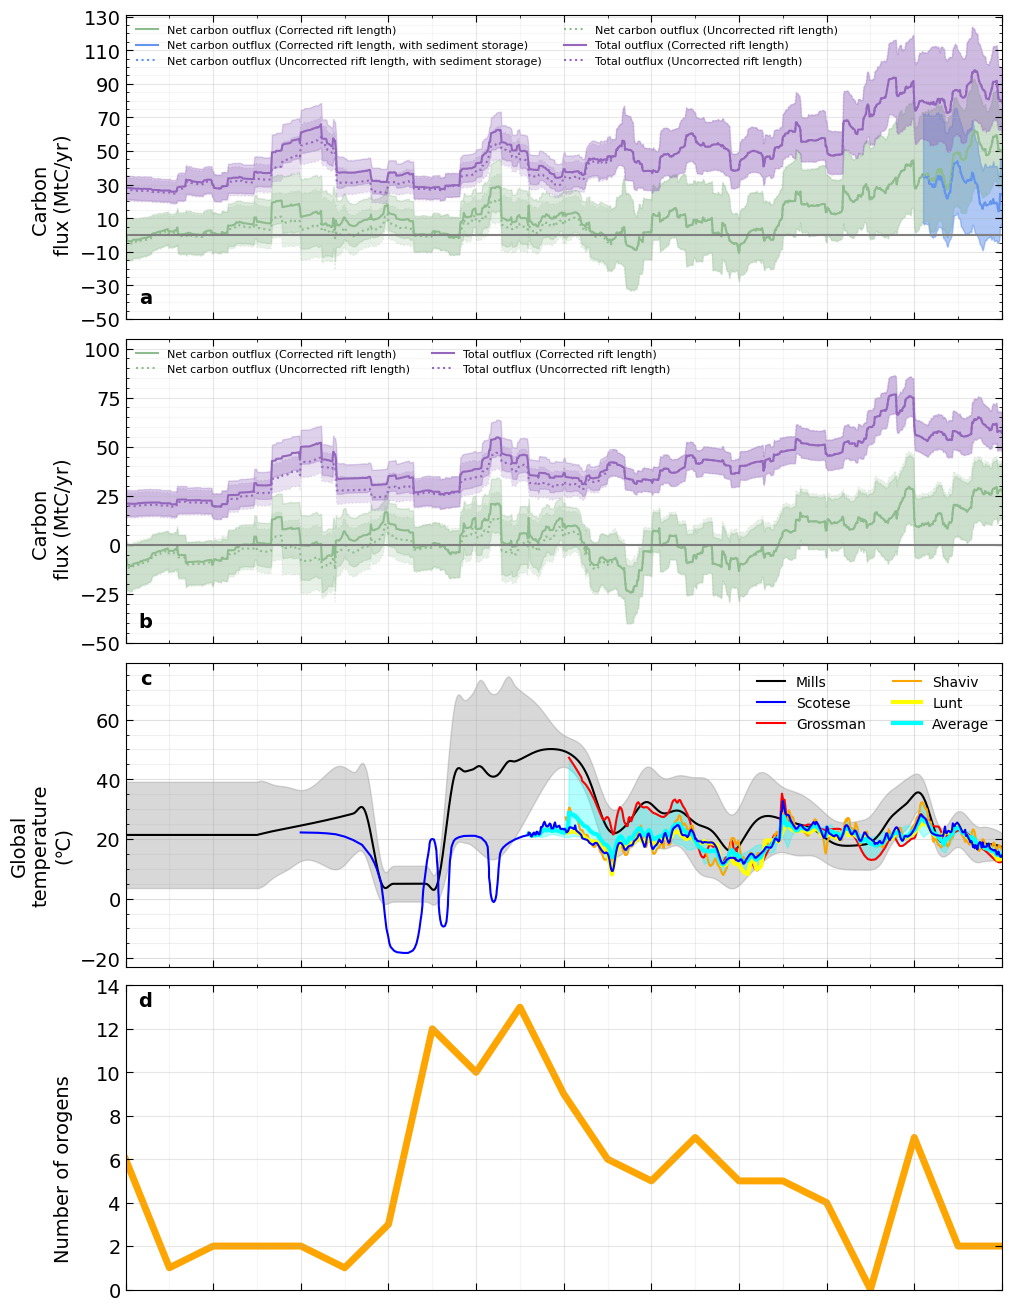

In [45]:
# PLOT THE ARRAYS ABOVE 

fig = plt.figure(figsize=(7,2))
#ax = fig.add_subplot(3,1,1, xlim=[max_time,0])
fig, (ax, ax1, ax3, ax5)  = plt.subplots(ncols=1, nrows=4, figsize=(10,13), constrained_layout=True, height_ratios=[1,1,1,1])


# PANEL A: Difference between gross atmospheric influx and gross upper plate influx (without sediment) (MtC/a)
# Difference
ax.set_xlim([max_time,0])
ax.set_ylim([-50., 131])

# Net carbon influx no sed, unbiased rifts
ax.fill_between(reconstruction_times,
                min_net_atmospheric_influx_no_sed,
                max_net_atmospheric_influx_no_sed,
                color='darkseagreen', alpha=0.3)
ax.plot(reconstruction_times, mean_net_atmospheric_influx_no_sed, c="darkseagreen", label="Net carbon outflux (Corrected rift length)")
ax.set_ylabel('Carbon \n flux (MtC/yr)', rotation='vertical', fontsize=14)

# Net carbon influx no sed upper plate influx and including sediment storage reservoir, unbiased rifts
ax.fill_between(sed_storage_time,
                min_net_atmospheric_influx_with_sediment_storage[:91],
                max_net_atmospheric_influx_with_sediment_storage[:91],
                color="cornflowerblue", alpha=0.3)
ax.plot(sed_storage_time, mean_net_atmospheric_influx_with_sediment_storage[:91], c="cornflowerblue", label="Net carbon outflux (Corrected rift length, with sediment storage)")
ax.set_ylabel('Carbon \n flux (MtC/yr)', rotation='vertical', fontsize=14)


# Net carbon influx no sed upper plate influx and including sediment storage reservoir, biased rifts
ax.fill_between(sed_storage_time,
                min_net_atmospheric_influx_with_sediment_storage_biased[:91],
                max_net_atmospheric_influx_with_sediment_storage_biased[:91],
                color="cornflowerblue", alpha=0.3)
ax.plot(sed_storage_time, mean_net_atmospheric_influx_with_sediment_storage_biased[:91], c="cornflowerblue",  linestyle=":", label="Net carbon outflux (Uncorrected rift length, with sediment storage)")
ax.set_ylabel('Carbon \n flux (MtC/yr)', rotation='vertical', fontsize=14)



# Net carbon outflux with non-corrected (biased) rift degassing (no sediment)
ax.fill_between(reconstruction_times,
                min_net_atmospheric_influx_biased,
                max_net_atmospheric_influx_biased,
                color='darkseagreen', alpha=0.2, linestyle=":",)
ax.plot(reconstruction_times, mean_net_atmospheric_influx_biased, linestyle=":", c="darkseagreen", label='Net carbon outflux (Uncorrected rift length)')


ax.tick_params(direction="in", which='major', length=5,   bottom=True, top=True, right=True)
ax.tick_params(direction='in', which='minor', length=2.5, bottom=False, top=True, right=True)

ax.tick_params(axis='x', which='minor', bottom=True)
ax.set_xticklabels([])
ax.spines['bottom'].set_visible(True)
ax.yaxis.set_ticks(
    np.arange(-50., 131., 5.),
    minor=True)
ax.yaxis.set_ticks(
    np.arange(-50., 131., 20.),
    major=True)

# Gross atmospheric influx with corrected rift degassing (unbiased)
ax.fill_between(reconstruction_times,
                total_atmospheric_influx_with_rifts[:,0],
                total_atmospheric_influx_with_rifts[:,2],
                color='C4', alpha=0.3)
ax.plot(reconstruction_times, total_atmospheric_influx_with_rifts[:,1], c="C4", label="Total outflux (Corrected rift length)")

# Gross atmosphere influx with non-corrected rift degassing (biased)
ax.fill_between(reconstruction_times,
                total_atmospheric_influx_with_biased_rifts[:,0],
                total_atmospheric_influx_with_biased_rifts[:,2],
                color='C4', alpha=0.2, linestyle=":",)
ax.plot(reconstruction_times, total_atmospheric_influx_with_biased_rifts[:,1], c="C4", 
        label='Total outflux (Uncorrected rift length)', linestyle=":")

# Partition net outflux and net influx
ax.plot(reconstruction_times, np.zeros(len(reconstruction_times),), color='0.5')
ax.xaxis.set_ticks(np.arange(max_time, min_time, -50.),minor=True)
ax.xaxis.set_ticks(np.arange(max_time, min_time-1, -100.),major=True)
ax.grid(alpha=0.1, which='both')
ax.grid(alpha=0.3, which='major')

ax.legend(fontsize=8, loc='upper left', ncol=2, frameon=False)


# ------------------------------------------------------------------------------------------------
# PANEL B: As for Panel A, except using Ratschbacher flux
ax1.set_xlim([max_time,0])
ax1.set_ylim([-50., 100])

# Net carbon influx (unbiased, no sediment)
ax1.fill_between(reconstruction_times,
                ratschbacher_min_net_atmospheric_influx_non_biased,
                ratschbacher_max_net_atmospheric_influx_non_biased,
                color='darkseagreen', alpha=0.3)
ax1.plot(reconstruction_times, ratschbacher_mean_net_atmospheric_influx_non_biased, c="darkseagreen", label="Net carbon outflux (Corrected rift length)")
ax1.set_ylabel('Carbon \n flux (MtC/yr)', rotation='vertical', fontsize=14)


# Net carbon outflux with non-corrected rift degassing (biased, no sediment)
ax1.fill_between(reconstruction_times,
                ratschbacher_min_net_atmospheric_influx_no_sed,
                ratschbacher_max_net_atmospheric_influx_no_sed,
                color='darkseagreen', alpha=0.2, linestyle=":",)
ax1.plot(reconstruction_times, ratschbacher_mean_net_atmospheric_influx_no_sed, linestyle=":", c="darkseagreen", label='Net carbon outflux (Uncorrected rift length)')

ax1.tick_params(direction="in", which='major', length=5,   bottom=True, top=True, right=True)
ax1.tick_params(direction='in', which='minor', length=2.5, bottom=False, top=True, right=True)

ax1.tick_params(axis='x', which='minor', bottom=True)
ax1.set_xticklabels([])
ax1.spines['bottom'].set_visible(True)
ax1.yaxis.set_ticks(
    np.arange(-50., 110., 5.),
    minor=True)

# Gross atmospheric influx with corrected rift degassing (Unbiased)
ax1.fill_between(reconstruction_times,
                ratschbacher_total_atmospheric_influx_with_non_biased_rifts[:,0],
                ratschbacher_total_atmospheric_influx_with_non_biased_rifts[:,2],
                color='C4', alpha=0.3)
ax1.plot(reconstruction_times, ratschbacher_total_atmospheric_influx_with_non_biased_rifts[:,1], c="C4", label="Total outflux (Corrected rift length)")


# Gross atmosphere influx with non-corrected rift degassing (biased)
ax1.fill_between(reconstruction_times,
                ratschbacher_total_atmospheric_influx_with_rifts[:,0],
                ratschbacher_total_atmospheric_influx_with_rifts[:,2],
                color='C4', alpha=0.2, linestyle=":",)
ax1.plot(reconstruction_times, ratschbacher_total_atmospheric_influx_with_rifts[:,1], c="C4", 
        label='Total outflux (Uncorrected rift length)', linestyle=":")

# Partition net outflux and net influx
ax1.plot(reconstruction_times, np.zeros(len(reconstruction_times),), color='0.5')
ax1.xaxis.set_ticks(np.arange(max_time, min_time, -50.),minor=True)
ax1.xaxis.set_ticks(np.arange(max_time, min_time-1, -100.),major=True)
ax1.grid(alpha=0.1, which='both')
ax1.grid(alpha=0.3, which='major')

ax1.legend(fontsize=8, loc='upper left', ncol=2, frameon=False)

"""
# ------------------------------------------------------------------------------------------------
# PANEL C: Ratio between gross atmospheric influx and gross upper plate influx (with sediment) (MtC/a)
ax2.set_xlim([max_time,0])
ax2.set_ylim([0,2.5])
ax2.set_ylabel('Carbon \noutflux/influx \nratio', rotation='vertical', fontsize=14)

# Ratio of gross total atmospheric influx to gross upper plate influx (biased rifts)
ax2.fill_between(reconstruction_times,
                min_gross_outflux_to_gross_influx_with_rifts,
                max_gross_outflux_to_gross_influx_with_rifts,
                color='#EE6363', alpha=0.3)
ax2.plot(reconstruction_times, mean_gross_outflux_to_gross_influx_with_rifts, c="#EE6363", label="Bias-corrected rift length")


# Ratio of gross total atmospheric influx to gross upper plate influx (non-biased rifts)
ax2.fill_between(reconstruction_times,
                min_gross_outflux_to_gross_influx_with_non_biased_rifts,
                max_gross_outflux_to_gross_influx_with_non_biased_rifts,
                color='#EE6363', alpha=0.2, linestyle=":",)
ax2.plot(reconstruction_times, mean_gross_outflux_to_gross_influx_with_non_biased_rifts, linestyle=":", c="#EE6363", label="Uncorrected rift length")


ax2.tick_params(direction="in", which='major', length=5,   bottom=True, top=True, right=True)
ax2.tick_params(direction='in', which='minor', length=2.5, bottom=False, top=True, right=True)

ax2.tick_params(axis='x', which='minor', bottom=True)
ax2.xaxis.set_ticks(np.arange(max_time, min_time, -50.),minor=True)
ax2.xaxis.set_ticks(np.arange(max_time, min_time-1, -100.),major=True)
ax2.set_xticklabels([])
ax2.spines['bottom'].set_visible(True)
ax2.grid(alpha=0.1, which='both')
ax2.grid(alpha=0.3, which='major')
ax2.yaxis.set_ticks(np.arange(0, 2.51, 0.125),minor=True)
ax2.legend(fontsize=8, loc='lower left', ncol=2, frameon=False)

# ------------------------------------------------------------------------------------------------
# Panel D - As for Panel C, except using Ratschbacher flux
ax4.set_xlim([max_time,0])
ax4.set_ylim([0,3.])
ax4.set_ylabel('Carbon \noutflux/influx \nratio', rotation='vertical', fontsize=14)


# Ratio of gross total atmospheric influx to gross upper plate influx (biased rifts)
ax4.fill_between(reconstruction_times,
                ratschbacher_min_gross_outflux_to_gross_influx_with_rifts,
                ratschbacher_max_gross_outflux_to_gross_influx_with_rifts,
                color='#EE6363', alpha=0.3)
ax4.plot(reconstruction_times, ratschbacher_mean_gross_outflux_to_gross_influx_with_rifts, c="#EE6363", label="Bias-corrected rift length")


# Ratio of gross total atmospheric influx to gross upper plate influx (non-biased rifts)
ax4.fill_between(reconstruction_times,
                min_gross_outflux_to_gross_influx_with_non_biased_rifts,
                max_gross_outflux_to_gross_influx_with_non_biased_rifts,
                color='#EE6363', alpha=0.2, linestyle=":",)
ax4.plot(reconstruction_times, mean_gross_outflux_to_gross_influx_with_non_biased_rifts, linestyle=":", c="#EE6363", label="Uncorrected rift length")


ax4.tick_params(direction="in", which='major', length=5,   bottom=True, top=True, right=True)
ax4.tick_params(direction='in', which='minor', length=2.5, bottom=False, top=True, right=True)


ax4.tick_params(axis='x', which='minor', bottom=True)
ax4.xaxis.set_ticks(np.arange(max_time, min_time, -50.),minor=True)
ax4.xaxis.set_ticks(np.arange(max_time, min_time-1, -100.),major=True)
ax4.set_xticklabels([])
ax4.spines['bottom'].set_visible(True)
ax4.grid(alpha=0.1, which='both')
ax4.grid(alpha=0.3, which='major')
ax4.yaxis.set_ticks(np.arange(0, 3.01, 0.125),minor=True)
ax4.legend(fontsize=8, loc='lower left', ncol=2, frameon=False)
"""

# ------------------------------------------------------------------------------------------------
# Panel E - GAST
# GAST - Mills
ax3.fill_between(reconstruction_times,
                GAST_min,
                GAST_max,
                color='0.5', alpha=0.3, zorder=1)
ax3.plot(reconstruction_times, GAST_mean, c='k', label='Mills')


# GAST - Scotese
ax3.plot(scotese_time, scotese_temp, c="blue", label="Scotese", zorder=9)
ax3.grid(alpha=0.1, which='both')
ax3.grid(alpha=0.3, which='major')

ax3.set_xlim([max_time,0])
ax3.tick_params(direction="in", which='major', length=5,   top=True, right=True)
ax3.tick_params(direction='in', which='minor', length=2.5, top=True, right=True)
ax3.minorticks_on()
ax3.set_ylabel('Global\ntemperature\n(\u2103)', rotation='vertical', fontsize=14)

ax3.minorticks_on()
ax3.xaxis.set_ticks(np.arange(max_time, min_time, -50.),minor=True)
ax3.xaxis.set_ticks(np.arange(max_time, min_time-1, -100.),major=True)
ax3.grid(alpha=0.2, which='both')
ax3.grid(alpha=0.4, which='major')
ax3.set_xticklabels([])
ax3.patch.set_visible(False)



# GAST - Grossman
ax3.plot(grossman_age, grossman_temp, color='r', label='Grossman')


# GAST - Shaviv
ax3.plot(average_age, shaviv_temp, color='orange', label='Shaviv')

# GAST - Lunt
ax3.plot(average_age, lunt_temp, color='yellow', linewidth=3, label='Lunt')

# GAST - average
ax3.plot(average_age, average_temp, color='cyan', linewidth=3, label='Average')
ax3.fill_between(average_age, absolute_min, absolute_max, alpha=0.3, color='cyan')

ax3.legend(frameon=False, loc='upper right', ncol=2)

fig.subplots_adjust(hspace=0.05)
ax.yaxis.set_label_coords(-0.06, 0.4)
ax1.yaxis.set_label_coords(-0.06, 0.4)
ax3.yaxis.set_label_coords(-0.06, 0.4)
ax5.yaxis.set_label_coords(-0.05, 0.4)


# ------------------------------------------------------------------------------------------------
# PANEL 6 - Orogens
ax5.plot(orogens_txt['Age'].to_numpy().astype('float'), orogens_txt['Frequency'].to_numpy().astype('float'), color='orange', linewidth=5, zorder=-1)
ax5.set_ylabel("Number of orogens", rotation='vertical', fontsize=14,)
ax5.tick_params(axis='y', labelsize=14)
ax5.set_ylim([0,14])
ax5.set_xlim([max_time,0])
ax5.yaxis.set_ticks(np.arange(0, 15, 2))
ax5.set_xticklabels([])
ax5.grid(alpha=0.1, which='both')
ax5.grid(alpha=0.3, which='major')
ax5.xaxis.set_ticks(np.arange(max_time, min_time, -50.),minor=True)
ax5.xaxis.set_ticks(np.arange(max_time, min_time-1, -100.),major=True)
ax5.tick_params(direction="in", which='major', length=5,   bottom=True, top=True, right=True)
ax5.tick_params(direction='in', which='minor', length=2.5, bottom=False, top=True, right=True)
ax5.yaxis.set_label_coords(-0.06, 0.4)

img_id = ["a","b","c","d", "e"]

for i, ax in enumerate([ax,ax1, ax3, ax5]):

    ax.tick_params(axis='y', which='major', labelsize=14)
    
    if i==0 or i==1:
        ax.annotate('{}'.format(img_id[i]), xy=(0.03, 0.1), xycoords='axes fraction', fontsize=14, fontweight="bold",
            horizontalalignment='right', verticalalignment='top')
    else:
        ax.annotate('{}'.format(img_id[i]), xy=(0.03, 0.98), xycoords='axes fraction', fontsize=14, fontweight="bold",
            horizontalalignment='right', verticalalignment='top')
    
fig.savefig(output_directory+"/figures/diff_atmospheric_flux_both_rift_options_gast_ratschbacher.pdf", bbox_inches='tight', dpi=600)
fig.savefig(output_directory+"/figures/diff_atmospheric_flux_both_rift_options_gast_ratschbacher.svg", bbox_inches='tight', dpi=600)
fig.savefig(output_directory+"/figures/diff_atmospheric_flux_both_rift_options_gast_ratschbacher.png", bbox_inches='tight', dpi=600)


In [46]:
# Mean and median net degassing - Ratschbacher
print("Mean net carbon degassing (Ratschbacher): {} MtC/yr".format(np.mean(ratschbacher_mean_net_atmospheric_influx_no_sed)))
print("Mean net carbon degassing (non biased rifts, Ratschbacher): {} MtC/yr".format(np.mean(ratschbacher_mean_net_atmospheric_influx_non_biased)))

print("Median net carbon degassing (Ratschbacher): {} MtC/yr".format(np.median(ratschbacher_mean_net_atmospheric_influx_no_sed)))
print("Median net carbon degassing (non biased rifts, Ratschbacher): {} MtC/yr".format(np.median(ratschbacher_mean_net_atmospheric_influx_non_biased)))

Mean net carbon degassing (Ratschbacher): 1.5727870514819522 MtC/yr
Mean net carbon degassing (non biased rifts, Ratschbacher): 3.6552955244016996 MtC/yr
Median net carbon degassing (Ratschbacher): -1.121065544130449 MtC/yr
Median net carbon degassing (non biased rifts, Ratschbacher): 2.619989175509204 MtC/yr


In [47]:
# Mean and median net degassing - original carbonate platform degassing
print("Mean net carbon degassing: {} MtC/yr".format(np.mean(mean_net_atmospheric_influx_biased)))
print("Mean net carbon degassing (non biased rifts): {} MtC/yr".format(np.mean(mean_net_atmospheric_influx_no_sed)))
print("Mean net carbon degassing (with sed storage): {} MtC/yr".format(np.mean(mean_net_atmospheric_influx_with_sediment_storage)))

print("Median net carbon degassing: {} MtC/yr".format(np.median(mean_net_atmospheric_influx_biased)))
print("Median net carbon degassing (non biased rifts): {} MtC/yr".format(np.median(mean_net_atmospheric_influx_no_sed)))
print("Median net carbon degassing (with sed storage): {} MtC/yr".format(np.median(mean_net_atmospheric_influx_with_sediment_storage)))


Mean net carbon degassing: 10.660824887974497 MtC/yr
Mean net carbon degassing (non biased rifts): 12.743333360894244 MtC/yr
Mean net carbon degassing (with sed storage): 11.218952786092048 MtC/yr
Median net carbon degassing: 5.089106722455213 MtC/yr
Median net carbon degassing (non biased rifts): 9.333079220565736 MtC/yr
Median net carbon degassing (with sed storage): 9.333079220565736 MtC/yr


In [48]:
# Save to csv (without Scotese)
data_out = np.column_stack(
    (
        
        # Gross atmospheric influx biased rifts
        total_atmospheric_influx_with_biased_rifts,
        
        # Ratschbacher Gross atmospheric influx biased rifts
        ratschbacher_total_atmospheric_influx_with_rifts,
        
        # Gross atmospheric influx - no sed, non-biased rifts
        total_atmospheric_influx_with_rifts,
        
        # Ratschbacher gross atmospheric influx - no sed, non-biased rifts
        ratschbacher_total_atmospheric_influx_with_non_biased_rifts,
        
        # Net atmospheric influx - no sediment, using unbiased rifts
        min_net_atmospheric_influx_no_sed,
        mean_net_atmospheric_influx_no_sed,
        max_net_atmospheric_influx_no_sed,
        
        # Net atmospheric influx - no sediment, including sediment storage, using unbiased rifts
        min_net_atmospheric_influx_with_sediment_storage,
        mean_net_atmospheric_influx_with_sediment_storage,
        max_net_atmospheric_influx_with_sediment_storage,
        
        # Ratschbacher net atmospheric influx - no sediment, using unbiased rifts
        ratschbacher_min_net_atmospheric_influx_non_biased,
        ratschbacher_mean_net_atmospheric_influx_non_biased,
        ratschbacher_max_net_atmospheric_influx_non_biased,
        
        # Net atmospheric influx - no sediment, using biased rifts
        min_net_atmospheric_influx_biased,
        mean_net_atmospheric_influx_biased,
        max_net_atmospheric_influx_biased,
        
        # Ratschbacher net atmospheric influx - no sediment, using biased rifts
        ratschbacher_min_net_atmospheric_influx_no_sed,
        ratschbacher_mean_net_atmospheric_influx_no_sed,
        ratschbacher_max_net_atmospheric_influx_no_sed,
        
        # Ratio of gross atm outflux to gross plate influx, considering unbiased rifts, WITH SEDIMENT
        min_gross_outflux_to_gross_influx_with_rifts,
        mean_gross_outflux_to_gross_influx_with_rifts,
        max_gross_outflux_to_gross_influx_with_rifts,
        
        # Ratschbacher Ratio of gross atm outflux to gross plate influx, considering unbiased rifts, WITH SEDIMENT
        ratschbacher_min_gross_outflux_to_gross_influx_with_non_biased_rifts,
        ratschbacher_mean_gross_outflux_to_gross_influx_with_non_biased_rifts,
        ratschbacher_max_gross_outflux_to_gross_influx_with_non_biased_rifts,
        
        # Ratio of gross atm outflux to gross plate influx, considering biased rifts, WITH SEDIMENT
        min_gross_outflux_to_gross_influx_with_biased_rifts,
        mean_gross_outflux_to_gross_influx_with_biased_rifts,
        max_gross_outflux_to_gross_influx_with_biased_rifts,
        
        # Ratschbacher ratio of gross atm outflux to gross plate influx, considering biased rifts, WITH SEDIMENT
        ratschbacher_min_gross_outflux_to_gross_influx_with_rifts,
        ratschbacher_mean_gross_outflux_to_gross_influx_with_rifts,
        ratschbacher_max_gross_outflux_to_gross_influx_with_rifts,
        
        # GAST time series
        GAST_min,
        GAST_mean,
        GAST_max
    )
)

headers = [
    "gross_atmospheric_influx_no_sed_biased_rifts",
    "ratschbacher_gross_atmospheric_influx_no_sed_biased_rifts",
    "gross_atmospheric_influx_no_sed_unbiased_rifts",
    "ratschbacher_gross_atmospheric_influx_no_sed_unbiased_rifts",
    "net_carbon_outflux_no_sed_unbiased_rifts",
    "net_carbon_outflux_no_sed_with_sediment_storage_unbiased_rifts",
    "ratschbacher_net_carbon_outflux_no_sed_unbiased_rifts",
    "net_carbon_outflux_no_sed_biased_rifts",
    "ratschbacher_net_carbon_outflux_no_sed_biased_rifts",
    "carbon_flux_ratio_with_sed_unbiased_rifts",
    "ratschbacher_carbon_flux_ratio_with_sed_unbiased_rifts",
    "carbon_flux_ratio_with_sed_biased_rifts",
    "ratschbacher_carbon_flux_ratio_with_sed_biased_rifts",
    "GAST"
]
quantiles = ['min', 'mean', 'max']
index = pd.MultiIndex.from_product([headers, quantiles])

df_net_carbon_flux = pd.DataFrame(list(data_out), columns = index, index=reconstruction_times) 
df_net_carbon_flux.to_csv(output_directory+"/csv/05_carbon_flux.csv", index_label='Age (Ma)')


In [49]:
# Save to csv (without Scotese)
data_out = np.column_stack(
    (
        

        # Net atmospheric influx - no sediment, using unbiased rifts
        min_net_atmospheric_influx_no_sed,
        mean_net_atmospheric_influx_no_sed,
        max_net_atmospheric_influx_no_sed,
        
        # Net atmospheric influx - no sediment, including sediment storage, using unbiased rifts
        min_net_atmospheric_influx_with_sediment_storage,
        mean_net_atmospheric_influx_with_sediment_storage,
        max_net_atmospheric_influx_with_sediment_storage,
        
        # Net atmospheric influx - no sediment, including sediment storage, using biased rifts
        min_net_atmospheric_influx_with_sediment_storage_biased,
        mean_net_atmospheric_influx_with_sediment_storage_biased,
        max_net_atmospheric_influx_with_sediment_storage_biased,
        
        # Ratschbacher net atmospheric influx - no sediment, using unbiased rifts
        ratschbacher_min_net_atmospheric_influx_non_biased,
        ratschbacher_mean_net_atmospheric_influx_non_biased,
        ratschbacher_max_net_atmospheric_influx_non_biased,
    )
)

headers = [
    "net_carbon_outflux",
    "net_carbon_outflux_with_sediment_storage",
    "net_carbon_outflux_with_sediment_storage_biased",
    "ratschbacher_net_carbon_outflux",
]
quantiles = ['min', 'mean', 'max']
index = pd.MultiIndex.from_product([headers, quantiles])

df_net_carbon_outflux = pd.DataFrame(list(data_out), columns = index, index=reconstruction_times) 
df_net_carbon_outflux.to_csv(output_directory+"/csv/05_net_carbon_outflux.csv", index_label='Age (Ma)')


/var/folders/m1/2fztkj494gsfjr4gb3w20swh0000gn/T/ipykernel_3558/1002612403.py:119: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.


<Figure size 700x200 with 0 Axes>

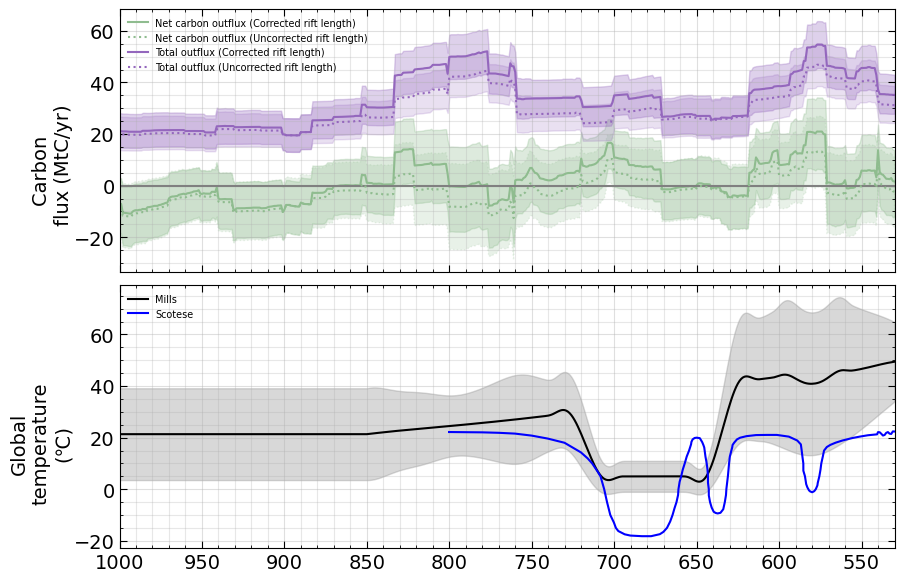

<Figure size 700x200 with 0 Axes>

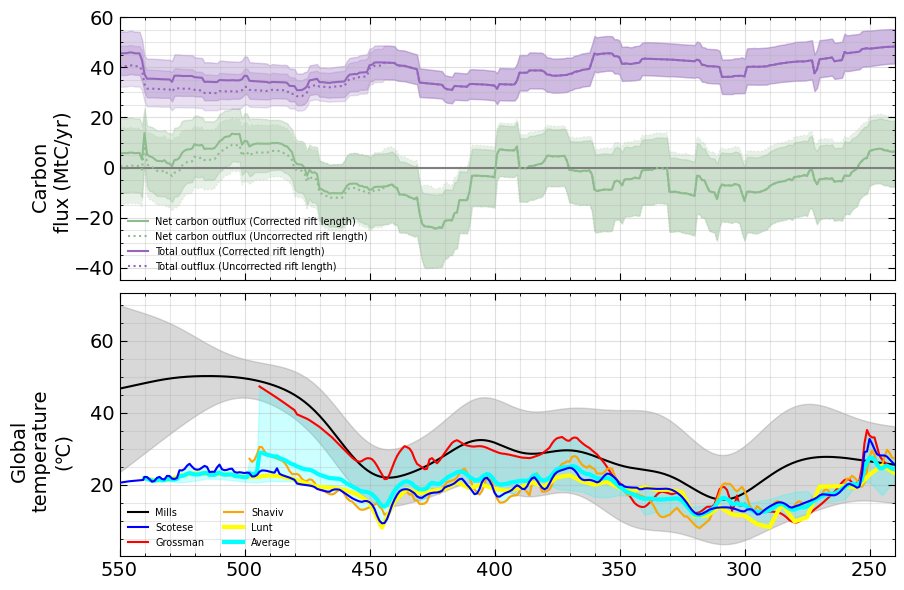

<Figure size 700x200 with 0 Axes>

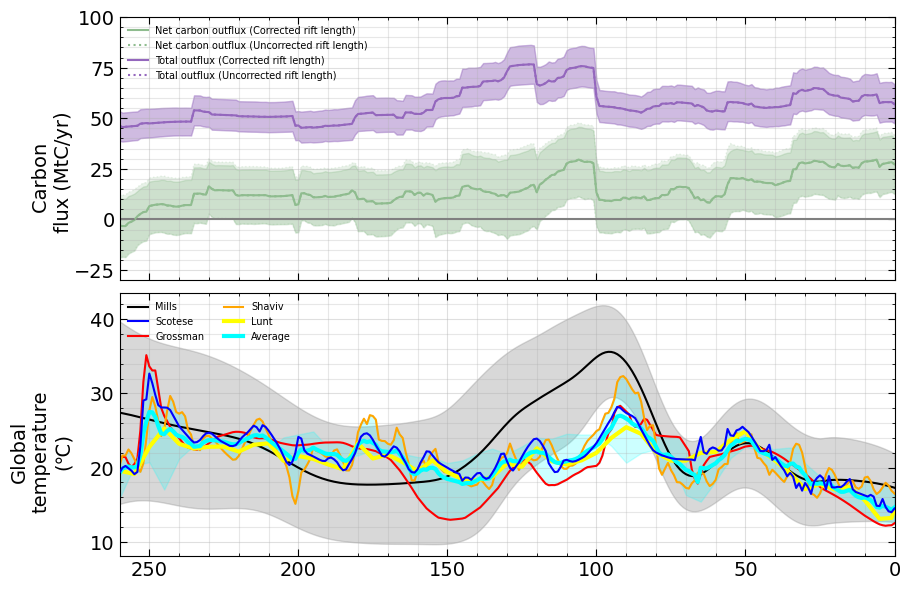

In [50]:
# PLOT THE ARRAYS ABOVE 


for j in range(0,3):
    fig = plt.figure(figsize=(7,2))
    #ax = fig.add_subplot(3,1,1, xlim=[max_time,0])
    fig, ((ax), (ax1))  = plt.subplots(ncols=1, nrows=2, figsize=(10,7), constrained_layout=True, height_ratios=[1,1])

    slice_start = [1000,550,260]
    slice_end = [530, 240, 0]

    axes = [ax, ax1]

    for i, ax in enumerate(axes):
        ax.tick_params(direction="in", which='major', length=5,   bottom=True, top=True, right=True)
        ax.tick_params(direction='in', which='minor', length=2.5, bottom=False, top=True, right=True)
        
        ax.xaxis.set_ticks(np.arange(slice_start[j], slice_end[j]-1, -10.),minor=True)
        ax.xaxis.set_ticks(np.arange(slice_start[j], slice_end[j]-1, -50.),major=True)

        ax.yaxis.set_ticks(np.arange(60,-40,-5),minor=True)

        ax.tick_params(axis='x', which='minor', bottom=True)

        if i == 0:
            ax.set_xlim([slice_start[j], slice_end[j]])


            # Net carbon influx no sed, non-biased rifts
            ax.fill_between(reconstruction_times[slice_end[j]:slice_start[j]+1],
                            ratschbacher_min_net_atmospheric_influx_non_biased[slice_end[j]:slice_start[j]+1],
                            ratschbacher_max_net_atmospheric_influx_non_biased[slice_end[j]:slice_start[j]+1],
                            color='darkseagreen', alpha=0.3)
            ax.plot(reconstruction_times[slice_end[j]:slice_start[j]+1], ratschbacher_mean_net_atmospheric_influx_non_biased[slice_end[j]:slice_start[j]+1], c="darkseagreen", label="Net carbon outflux (Corrected rift length)")
            ax.set_ylabel('Carbon \n flux (MtC/yr)', rotation='vertical', fontsize=14)

            ax.plot(reconstruction_times[slice_end[j]:slice_start[j]+1], np.zeros(len(reconstruction_times[slice_end[j]:slice_start[j]+1]),), color='0.5')
           
        # Net carbon outflux with non-corrected (biased) rift degassing (no sediment)
            ax.fill_between(reconstruction_times[slice_end[j]:slice_start[j]+1],
                            ratschbacher_min_net_atmospheric_influx_no_sed[slice_end[j]:slice_start[j]+1],
                            ratschbacher_max_net_atmospheric_influx_no_sed[slice_end[j]:slice_start[j]+1],
                            color='darkseagreen', alpha=0.2, linestyle=":",)
            ax.plot(reconstruction_times[slice_end[j]:slice_start[j]+1], ratschbacher_mean_net_atmospheric_influx_no_sed[slice_end[j]:slice_start[j]+1], linestyle=":", c="darkseagreen", label='Net carbon outflux (Uncorrected rift length)')

            # Gross atmosphere influx with corrected rift degassing
            ax.fill_between(reconstruction_times[slice_end[j]:slice_start[j]+1],
                            ratschbacher_total_atmospheric_influx_with_non_biased_rifts[:,0][slice_end[j]:slice_start[j]+1],
                            ratschbacher_total_atmospheric_influx_with_non_biased_rifts[:,2][slice_end[j]:slice_start[j]+1],
                            color='C4', alpha=0.3)
            ax.plot(reconstruction_times[slice_end[j]:slice_start[j]+1], ratschbacher_total_atmospheric_influx_with_non_biased_rifts[:,1][slice_end[j]:slice_start[j]+1], c="C4", 
                    label='Total outflux (Corrected rift length)',)
      
            # Gross atmospheric influx with non-corrected rift degassing
            ax.fill_between(reconstruction_times[slice_end[j]:slice_start[j]+1],
                            ratschbacher_total_atmospheric_influx_with_rifts[:,0][slice_end[j]:slice_start[j]+1],
                            ratschbacher_total_atmospheric_influx_with_rifts[:,2][slice_end[j]:slice_start[j]+1],
                            color='C4', alpha=0.2)
            ax.plot(reconstruction_times[slice_end[j]:slice_start[j]+1], ratschbacher_total_atmospheric_influx_with_rifts[:,1][slice_end[j]:slice_start[j]+1], c="C4", label="Total outflux (Uncorrected rift length)",
                    linestyle=":")

            
        if i == 1:
            ax.set_xlim([slice_start[j], slice_end[j]])
            
            ax.fill_between(reconstruction_times[slice_end[j]:slice_start[j]+1],
                GAST_min[slice_end[j]:slice_start[j]+1],
                GAST_max[slice_end[j]:slice_start[j]+1],
                color='0.5', alpha=0.3, zorder=1)
            ax.plot(reconstruction_times[slice_end[j]:slice_start[j]+1], GAST_mean[slice_end[j]:slice_start[j]+1], c='k', label='Mills')

            # GAST - Scotese
            ax.plot(scotese_time[slice_end[j]:slice_start[j]+1], scotese_temp[slice_end[j]:slice_start[j]+1], c="blue", label="Scotese", zorder=9)
            ax.minorticks_on()
            ax.set_ylabel('Global\ntemperature\n(\u2103)', rotation='vertical', fontsize=14)

            if j != 0:
                ax.plot(grossman_age[slice_end[j]:slice_start[j]+1], grossman_temp[slice_end[j]:slice_start[j]+1], color='r', label='Grossman')

                # GAST - Shaviv
                ax.plot(average_age[slice_end[j]:slice_start[j]+1], shaviv_temp[slice_end[j]:slice_start[j]+1], color='orange', label='Shaviv')

                # GAST - Lunt
                ax.plot(average_age[slice_end[j]:slice_start[j]+1], lunt_temp[slice_end[j]:slice_start[j]+1], color='yellow', linewidth=3, label='Lunt')

                # GAST - average
                ax.plot(average_age[slice_end[j]:slice_start[j]+1], average_temp[slice_end[j]:slice_start[j]+1], color='cyan', linewidth=3, label='Average')
                ax.fill_between(average_age[slice_end[j]:slice_start[j]+1], 
                                 absolute_min[slice_end[j]:slice_start[j]+1], 
                                 absolute_max[slice_end[j]:slice_start[j]+1], 
                                 alpha=0.2, color='cyan')
            ax.tick_params(axis='x', which='major', labelsize=14)
            
        if i != 1:
            ax.set_xticklabels([])
            ax.spines['bottom'].set_visible(True)
          
        if j == 2:
            # For minor ticks
            ax.xaxis.set_ticks(np.arange(250, -1, -10), minor=True)

            # For major ticks
            ax.xaxis.set_ticks(np.arange(250, -1, -50), major=True)
            if i != 1:
                ax.yaxis.set_ticks(np.arange(-30, 101, 5), minor=True)
        else:
            ax.xaxis.set_ticks(np.arange(reconstruction_times[slice_start[j]], reconstruction_times[slice_end[j]]-1,-10.),minor=True)
            ax.xaxis.set_ticks(np.arange(reconstruction_times[slice_start[j]], reconstruction_times[slice_end[j]]-1, -50.),major=True)

            
        ax.tick_params(direction="in", which='major', length=5,   top=True, right=True, bottom=True)
        ax.tick_params(direction='in', which='minor', length=2.5, top=True, right=True, bottom=True)
        
        ax.grid(alpha=0.3, which='both')
        ax.grid(alpha=0.4, which='major')
        
        ax.tick_params(axis='y', which='major', labelsize=14)
        #ax.set_xticklabels([])
        plt.subplots_adjust(hspace=0.05)
        ax.yaxis.set_label_coords(-0.06, 0.4)
        
        if j == 1:
            if i ==1:
                ax.legend(frameon=False, loc='lower left', prop={'size': 7}, ncols=2)
            else:
                ax.legend(frameon=False, loc='lower left', prop={'size': 7}, ncols=1)
        elif j == 2:
            if i ==0:
                ax.legend(frameon=False, loc='upper left', prop={'size': 7}, ncols=1)
            else:
                ax.legend(frameon=False, loc='upper left', prop={'size': 7}, ncols=2)
        else:
            ax.legend(frameon=False, loc='upper left', prop={'size': 7}, ncols=1)

        fig.savefig(output_directory+"/figures/{}-{}_diff_atmospheric_flux_both_rift_options_gast_ratschbacher.pdf".format(slice_start[j], slice_end[j]), bbox_inches='tight', dpi=600)
        fig.savefig(output_directory+"/figures/{}-{}_diff_atmospheric_flux_both_rift_options_gast_ratschbacher.svg".format(slice_start[j], slice_end[j]), bbox_inches='tight', dpi=600)
        fig.savefig(output_directory+"/figures/{}-{}_diff_atmospheric_flux_both_rift_options_gast_ratschbacher.png".format(slice_start[j], slice_end[j]), bbox_inches='tight', dpi=600)


Using original degassing:

/var/folders/m1/2fztkj494gsfjr4gb3w20swh0000gn/T/ipykernel_3558/1349373136.py:135: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.


<Figure size 700x200 with 0 Axes>

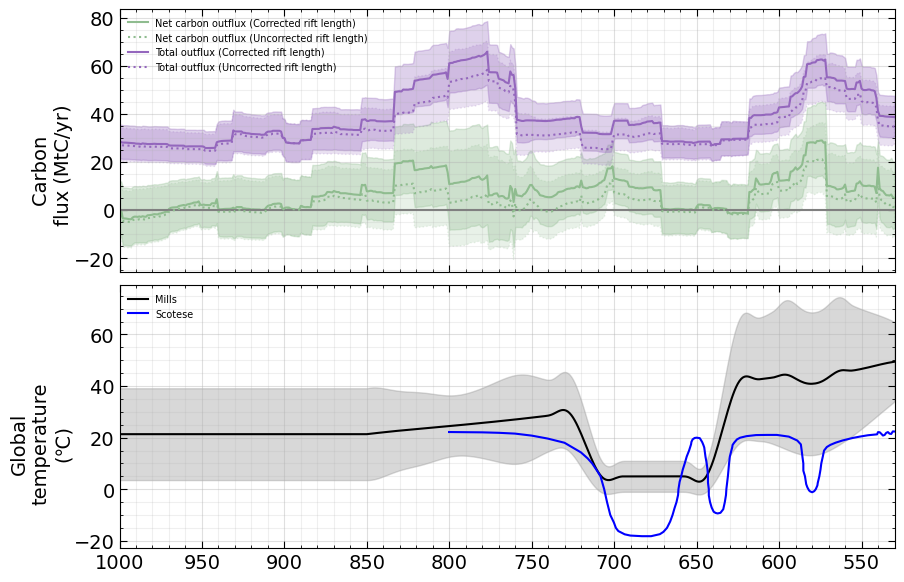

<Figure size 700x200 with 0 Axes>

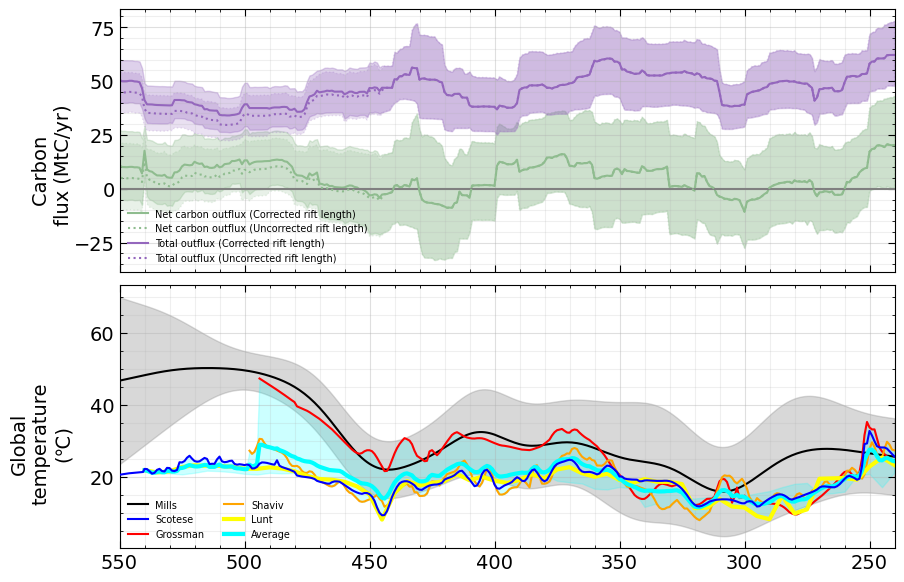

<Figure size 700x200 with 0 Axes>

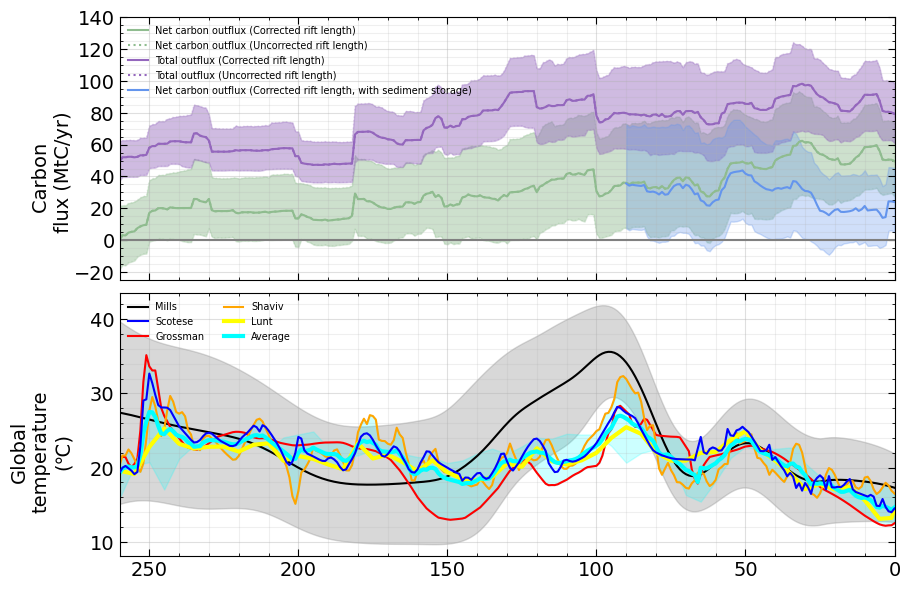

In [51]:
# PLOT THE ARRAYS ABOVE 


for j in range(0,3):
    fig = plt.figure(figsize=(7,2))
    #ax = fig.add_subplot(3,1,1, xlim=[max_time,0])
    fig, ((ax), (ax1))  = plt.subplots(ncols=1, nrows=2, figsize=(10,7), constrained_layout=True, height_ratios=[1,1])

    slice_start = [1000,550,260]
    slice_end = [530, 240, 0]

    axes = [ax, ax1]

    for i, ax in enumerate(axes):
        ax.tick_params(direction="in", which='major', length=5,   bottom=True, top=True, right=True)
        ax.tick_params(direction='in', which='minor', length=2.5, bottom=False, top=True, right=True)
        
        ax.xaxis.set_ticks(np.arange(slice_start[j], slice_end[j]-1, -10.),minor=True)
        ax.xaxis.set_ticks(np.arange(slice_start[j], slice_end[j]-1, -50.),major=True)

        ax.yaxis.set_ticks(np.arange(80,-40,-5),minor=True)

        ax.tick_params(axis='x', which='minor', bottom=True)

        if i == 0:

            ax.set_xlim([slice_start[j], slice_end[j]])
            
            if j == 2:
                ax.set_ylim([-25,140])
                ax.yaxis.set_ticks(np.arange(140,-26,-5),minor=True)
                ax.yaxis.set_ticks(np.arange(140,-26,-20),major=True)
            else:
                ax.yaxis.set_ticks(np.arange(140,-40,-5),minor=True)

            ax.tick_params(axis='x', which='minor', bottom=True)


            # Net carbon influx no sed, biased rifts
            ax.fill_between(reconstruction_times[slice_end[j]:slice_start[j]+1],
                            min_net_atmospheric_influx_no_sed[slice_end[j]:slice_start[j]+1],
                            max_net_atmospheric_influx_no_sed[slice_end[j]:slice_start[j]+1],
                            color='darkseagreen', alpha=0.3)
            ax.plot(reconstruction_times[slice_end[j]:slice_start[j]+1], mean_net_atmospheric_influx_no_sed[slice_end[j]:slice_start[j]+1], c="darkseagreen", label="Net carbon outflux (Corrected rift length)")
            ax.set_ylabel('Carbon \n flux (MtC/yr)', rotation='vertical', fontsize=14)

            ax.plot(reconstruction_times[slice_end[j]:slice_start[j]+1], np.zeros(len(reconstruction_times[slice_end[j]:slice_start[j]+1]),), color='0.5')
            # Net carbon outflux with non-corrected rift degassing (no sediment)
            ax.fill_between(reconstruction_times[slice_end[j]:slice_start[j]+1],
                            min_net_atmospheric_influx_biased[slice_end[j]:slice_start[j]+1],
                            max_net_atmospheric_influx_biased[slice_end[j]:slice_start[j]+1],
                            color='darkseagreen', alpha=0.2, linestyle=":",)
            ax.plot(reconstruction_times[slice_end[j]:slice_start[j]+1], mean_net_atmospheric_influx_biased[slice_end[j]:slice_start[j]+1], linestyle=":", c="darkseagreen", label='Net carbon outflux (Uncorrected rift length)')

            # Gross atmospheric influx with corrected rift degassing
            ax.fill_between(reconstruction_times[slice_end[j]:slice_start[j]+1],
                            total_atmospheric_influx_with_rifts[:,0][slice_end[j]:slice_start[j]+1],
                            total_atmospheric_influx_with_rifts[:,2][slice_end[j]:slice_start[j]+1],
                            color='C4', alpha=0.3)
            ax.plot(reconstruction_times[slice_end[j]:slice_start[j]+1], total_atmospheric_influx_with_rifts[:,1][slice_end[j]:slice_start[j]+1], c="C4", label="Total outflux (Corrected rift length)")

            # Gross atmosphere influx with non-corrected rift degassing
            ax.fill_between(reconstruction_times[slice_end[j]:slice_start[j]+1],
                            total_atmospheric_influx_with_biased_rifts[:,0][slice_end[j]:slice_start[j]+1],
                            total_atmospheric_influx_with_biased_rifts[:,2][slice_end[j]:slice_start[j]+1],
                            color='C4', alpha=0.2, linestyle=":",)
            ax.plot(reconstruction_times[slice_end[j]:slice_start[j]+1], total_atmospheric_influx_with_biased_rifts[:,1][slice_end[j]:slice_start[j]+1], c="C4", 
                    label='Total outflux (Uncorrected rift length)', linestyle=":")
            
                        
            if j == 2:
                # Net carbon influx no sed and NO sediment storage reservoir, unbiased rifts
                ax.fill_between(sed_storage_time,
                                min_net_atmospheric_influx_with_sediment_storage[:91],
                                max_net_atmospheric_influx_with_sediment_storage[:91],
                                color="cornflowerblue", alpha=0.3)
                ax.plot(sed_storage_time, mean_net_atmospheric_influx_with_sediment_storage[:91], c="cornflowerblue", label="Net carbon outflux (Corrected rift length, with sediment storage)")


            
        if i == 1:
            
            ax.set_xlim([slice_start[j], slice_end[j]])
            
            ax.fill_between(reconstruction_times[slice_end[j]:slice_start[j]+1],
                GAST_min[slice_end[j]:slice_start[j]+1],
                GAST_max[slice_end[j]:slice_start[j]+1],
                color='0.5', alpha=0.3, zorder=1)
            ax.plot(reconstruction_times[slice_end[j]:slice_start[j]+1], GAST_mean[slice_end[j]:slice_start[j]+1], c='k', label='Mills')

            # GAST - Scotese
            ax.plot(scotese_time[slice_end[j]:slice_start[j]+1], scotese_temp[slice_end[j]:slice_start[j]+1], c="blue", label="Scotese", zorder=9)
            ax.minorticks_on()
            ax.set_ylabel('Global\ntemperature\n(\u2103)', rotation='vertical', fontsize=14)

            if j != 0:
                ax.plot(grossman_age[slice_end[j]:slice_start[j]+1], grossman_temp[slice_end[j]:slice_start[j]+1], color='r', label='Grossman')

                # GAST - Shaviv
                ax.plot(average_age[slice_end[j]:slice_start[j]+1], shaviv_temp[slice_end[j]:slice_start[j]+1], color='orange', label='Shaviv')

                # GAST - Lunt
                ax.plot(average_age[slice_end[j]:slice_start[j]+1], lunt_temp[slice_end[j]:slice_start[j]+1], color='yellow', linewidth=3, label='Lunt')

                # GAST - average
                ax.plot(average_age[slice_end[j]:slice_start[j]+1], average_temp[slice_end[j]:slice_start[j]+1], color='cyan', linewidth=3, label='Average')
                ax.fill_between(average_age[slice_end[j]:slice_start[j]+1], 
                                 absolute_min[slice_end[j]:slice_start[j]+1], 
                                 absolute_max[slice_end[j]:slice_start[j]+1], 
                                 alpha=0.2, color='cyan')
            ax.tick_params(axis='x', which='major', labelsize=14)
            
        if i != 1:
            ax.set_xticklabels([])
            ax.spines['bottom'].set_visible(True)
          
        if j == 2:
            # For minor ticks
            ax.xaxis.set_ticks(np.arange(250, -1, -10), minor=True)

            # For major ticks
            ax.xaxis.set_ticks(np.arange(250, -1, -50), major=True)
        else:
            ax.xaxis.set_ticks(np.arange(reconstruction_times[slice_start[j]], reconstruction_times[slice_end[j]]-1,-10.),minor=True)
            ax.xaxis.set_ticks(np.arange(reconstruction_times[slice_start[j]], reconstruction_times[slice_end[j]]-1, -50.),major=True)

        ax.tick_params(direction="in", which='major', length=5,   top=True, right=True, bottom=True)
        ax.tick_params(direction='in', which='minor', length=2.5, top=True, right=True, bottom=True)
        
        ax.grid(alpha=0.2, which='both')
        ax.grid(alpha=0.4, which='major')
        
        ax.tick_params(axis='y', which='major', labelsize=14)
        #ax.set_xticklabels([])
        plt.subplots_adjust(hspace=0.05)
        ax.yaxis.set_label_coords(-0.06, 0.4)
        
        if j == 1:
            if i ==1:
                ax.legend(frameon=False, loc='lower left', prop={'size': 7}, ncols=2)
            else:
                ax.legend(frameon=False, loc='lower left', prop={'size': 7}, ncols=1)
        elif j == 2:
        
            if i ==0:
                ax.legend(frameon=False, loc='upper left', prop={'size': 7}, ncols=1)
            else:
                ax.legend(frameon=False, loc='upper left', prop={'size': 7}, ncols=2)
        else:
            ax.legend(frameon=False, loc='upper left', prop={'size': 7}, ncols=1)

        fig.savefig(output_directory+"/figures/{}-{}_diff_atmospheric_flux_both_rift_options_gast.pdf".format(slice_start[j], slice_end[j]), bbox_inches='tight', dpi=600)
        fig.savefig(output_directory+"/figures/{}-{}_diff_atmospheric_flux_both_rift_options_gast.svg".format(slice_start[j], slice_end[j]), bbox_inches='tight', dpi=600)
        fig.savefig(output_directory+"/figures/{}-{}_diff_atmospheric_flux_both_rift_options_gast.png".format(slice_start[j], slice_end[j]), bbox_inches='tight', dpi=600)


### Other data

In [52]:
data_out = [reconstruction_times,
            total_atmosphere_influx[:,0],
            total_atmosphere_influx[:,1],
            total_atmosphere_influx[:,2],
            subduction_atmosphere_influx[:,0],
            subduction_atmosphere_influx[:,1],
            subduction_atmosphere_influx[:,2],
            percentage_mantle_reservoir[:,0],
            percentage_mantle_reservoir[:,1],
            percentage_mantle_reservoir[:,2],
            overriding_plate_storage[:,0],
            overriding_plate_storage[:,1],
            overriding_plate_storage[:,2],
            plate_storage[:,0],
            plate_storage[:,1],
            plate_storage[:,2]
           ]

headers = ['time',
           'total_atmospheric_influx_min',
           'total_atmospheric_influx_mean',
           'total_atmospheric_influx_max',
           'subduction_atmospheric_influx_min',
           'subduction_atmospheric_influx_mean',
            'subduction_atmospheric_influx_max',
            'percentage_mantle_reservoir_min',
            'percentage_mantle_reservoir_mean',
            'percentage_mantle_reservoir_max',
            'overriding_plate_storage_min',
            'overriding_plate_storage_mean',
            'overriding_plate_storage_max',
            'slab_storage_min',
            'slab_storage_mean',
            'slab_storage_max']

df_atmospheric_flux = pd.DataFrame(np.column_stack(data_out), columns=headers, index=reconstruction_times)
df_atmospheric_flux.to_csv(output_directory+"/figures/05_overriding_plate_storage.csv", index_label='Age (Ma)')

Atmospheric carbon from Foster et al

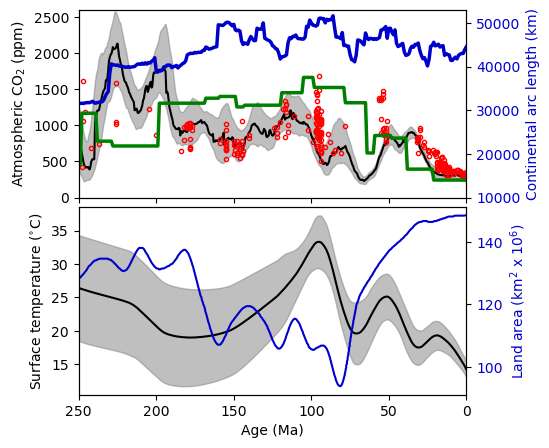

In [53]:

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(211, ylabel='Atmospheric CO$_2$ (ppm)', xlim=[250,0], ylim=[0,2600])
ax.fill_between(foster_age, foster_carbon[:,0], foster_carbon[:,2], color='0.5', alpha=0.5)
ax.plot(foster_age, foster_carbon[:,1], c="k", label='Total')
ax.plot(witkowski_age, witkowski_carbon, '.', c="Red", mfc='none')
ax.set_xticklabels([])

ax2 = ax.twinx()
# ax2.set_ylim(30e3, 53e3)
ax2.set_ylim(10e3, 53e3)
ax2.set_ylabel('Continental arc length (km)', color='mediumblue')
# ax2.fill_between(arc_time_muller, arc_len_muller_min, arc_len_muller_max, color='0.75', alpha=0.5)
ax2.plot(arc_time_muller, arc_len_muller_mean, c='mediumblue', linewidth=2.5)

# comparison with Cao et al
ax2.plot(arc_time_cao, arc_len_cao, c='green', linewidth=2.5)

# ax2.plot(arc_time_carb, arc_len_carb, c='red')
# ax2.plot(arc_time_merdith, arc_len_merdith, c='green')
# ax2.plot(arc_time_merdith, arc_len_merdith, c='green')
# ax2.tick_params(axis='y', labelcolor='Maroon')
ax2.tick_params(axis='y', labelcolor='mediumblue')

ax3 = fig.add_subplot(212, xlabel='Age (Ma)', xlim=[250,0])
ax3.fill_between(mills_time, mills_palaeotemp[:,1], mills_palaeotemp[:,2], color='0.5', alpha=0.5)
ax3.plot(mills_time, mills_palaeotemp[:,0], c='k')
ax3.set_ylabel('Surface temperature ($^{\circ}$C)')

ax4 = ax3.twinx()
# ax4.plot(bataille_age, bataille_sr, c='mediumblue')
ax4.tick_params(axis='y', labelcolor='mediumblue')
ax4.plot(marcilly_total_land_age, marcilly_total_land, c='mediumblue')
# ax3.plot(marcilly_exp_land_age, marcilly_exp_land, c='red')
ax4.set_ylabel('Land area (km$^{2}$ x 10$^{6}$)', color='mediumblue')

plt.subplots_adjust(hspace=0.05)

fig.savefig(output_directory+"/figures/CO2_arc_length.pdf", bbox_inches='tight', dpi=600)
fig.savefig(output_directory+"/figures/CO2_arc_length.svg", bbox_inches='tight', dpi=600)
fig.savefig(output_directory+"/figures/CO2_arc_length.png", bbox_inches='tight', dpi=600)